# Chasing Orbital Cyclicities in the Eastern Tropical Pacific

This notebook explores the results from the spectral, wavelet, and cross-wavelet analysis of a sea surface temperature reconstruction from Site ODP846 in the Eastern Equatorial Pacific. The worflow execution were done through [PaleoTS](http://linked.earth/paleoTS/), an automated system for the analysis of paleoclimate timeseries data. A description of the performed analyses is available [here](http://linked.earth/paleoTS/workflow.html).

This reproduces the work presented in [this Jupyter Notebook](https://github.com/LinkedEarth/PyleoclimPaper/blob/main/Orbital%20Cycles/Chasing%20orbital%20cyclicities.ipynb), which only took into consideration a fraction of the possible alternative methods for pre-processing and analysis.

First, let's import the necessary packages:
- the [wings package](https://pypi.org/project/wings/) (which allows to interface with the WINGS (PaleoTS) APIs without the GUI)
- Pandas, which will be used to query the results based on the specific outputs, parameters and combination thereof
- [Pyleoclim](https://pyleoclim-util.readthedocs.io/en/master/) to parse the results of the analyses.
- Seaborn for plotting purposes
- Numpy for basic array manipulation

In [108]:
import wings
from wings.execution import Execution
from wings.data import Data

import os.path
import json
import pandas as pd
import time
import datetime

import pyleoclim as pyleo

import seaborn as sns
import numpy as np

import getpass

The following cell contains login credentials for the runs on PaleoTS: 

In [2]:
SERVER = "https://datascience4all.org/wings-portal-new"
INTERNAL_SERVER = SERVER

USERID = "dkhider"
PASSWORD = getpass.getpass()
DOMAIN = "PaleoTS"

CACHEDIR = "data"

 ··········


Make a data folder if it doesn't already exist. Relevent outputs from PaleoTS will be downloaded to this folder. 

In [3]:
if os.path.exists('data')==True:
    pass
else:
    cwd = os.getcwd()+'/'
    path = os.path.join(cwd, 'data')
    os.mkdir(path)

In [4]:
api = wings.ApiClient(server=SERVER, username=USERID, password=PASSWORD)
api.set_domain(DOMAIN)

In [5]:
execution_api = Execution(api)
data_api = Data(api)

The functions below allow parsing for the parameters and output/intermediate files:

In [6]:
def get_execution_parameters(exec):
    variables = exec["variables"]
    params = {}
    for var in variables["input"]:
        if var["type"] == 2:
            vbinding = var["binding"]
            if vbinding["type"] == "literal":
                varname = var["id"].split("#")[1]
                #dtype = vbinding["datatype"].split("#")[1]
                value = vbinding["value"]
                params[varname] = value
    return params

def get_execution_files(exec, file_types=[], fetch_datasets_for_variables=[]):
    variables = exec["variables"]
    files = {}
    allvars = []

    for file_type in file_types:
        allvars += variables[file_type]
    for var in allvars:
        if var["type"] == 1:
            vbinding = var["binding"]
            if vbinding["type"] == "uri":
                varname = var["id"].split("#")[1]
                location = None
                dataid = vbinding["id"]
                dataname = dataid.split("#")[1]
                # Download datasets for variables if needed
                if varname in fetch_datasets_for_variables:
                    location = CACHEDIR + "/" + dataname
                    if not os.path.exists(location):
                        data_api.fetch_data(dataid, location)
                    files[varname] = location
    return files

## Data Exploration

Our first task was to extract the sea surface temperature data from the file and build a dashboard. Let's have a look at the dashboard directly. First let's fetch the executions corresponding to our *LiPDDashboard* run:

In [7]:
execs_dashboard = execution_api.list_executions_by_page(pattern="LiPDDashboard*")

The Run ID is `LiPDDashboard-ea79dfcc-5a32-487a-9e93-22c53ab6d1a2`. Let's use it to find our results:

In [8]:
runid = 'LiPDDashboard-ea79dfcc-5a32-487a-9e93-22c53ab6d1a2'
exec_dashboard = execution_api.get_run_details(runid)

Let's display the dashboard directly:

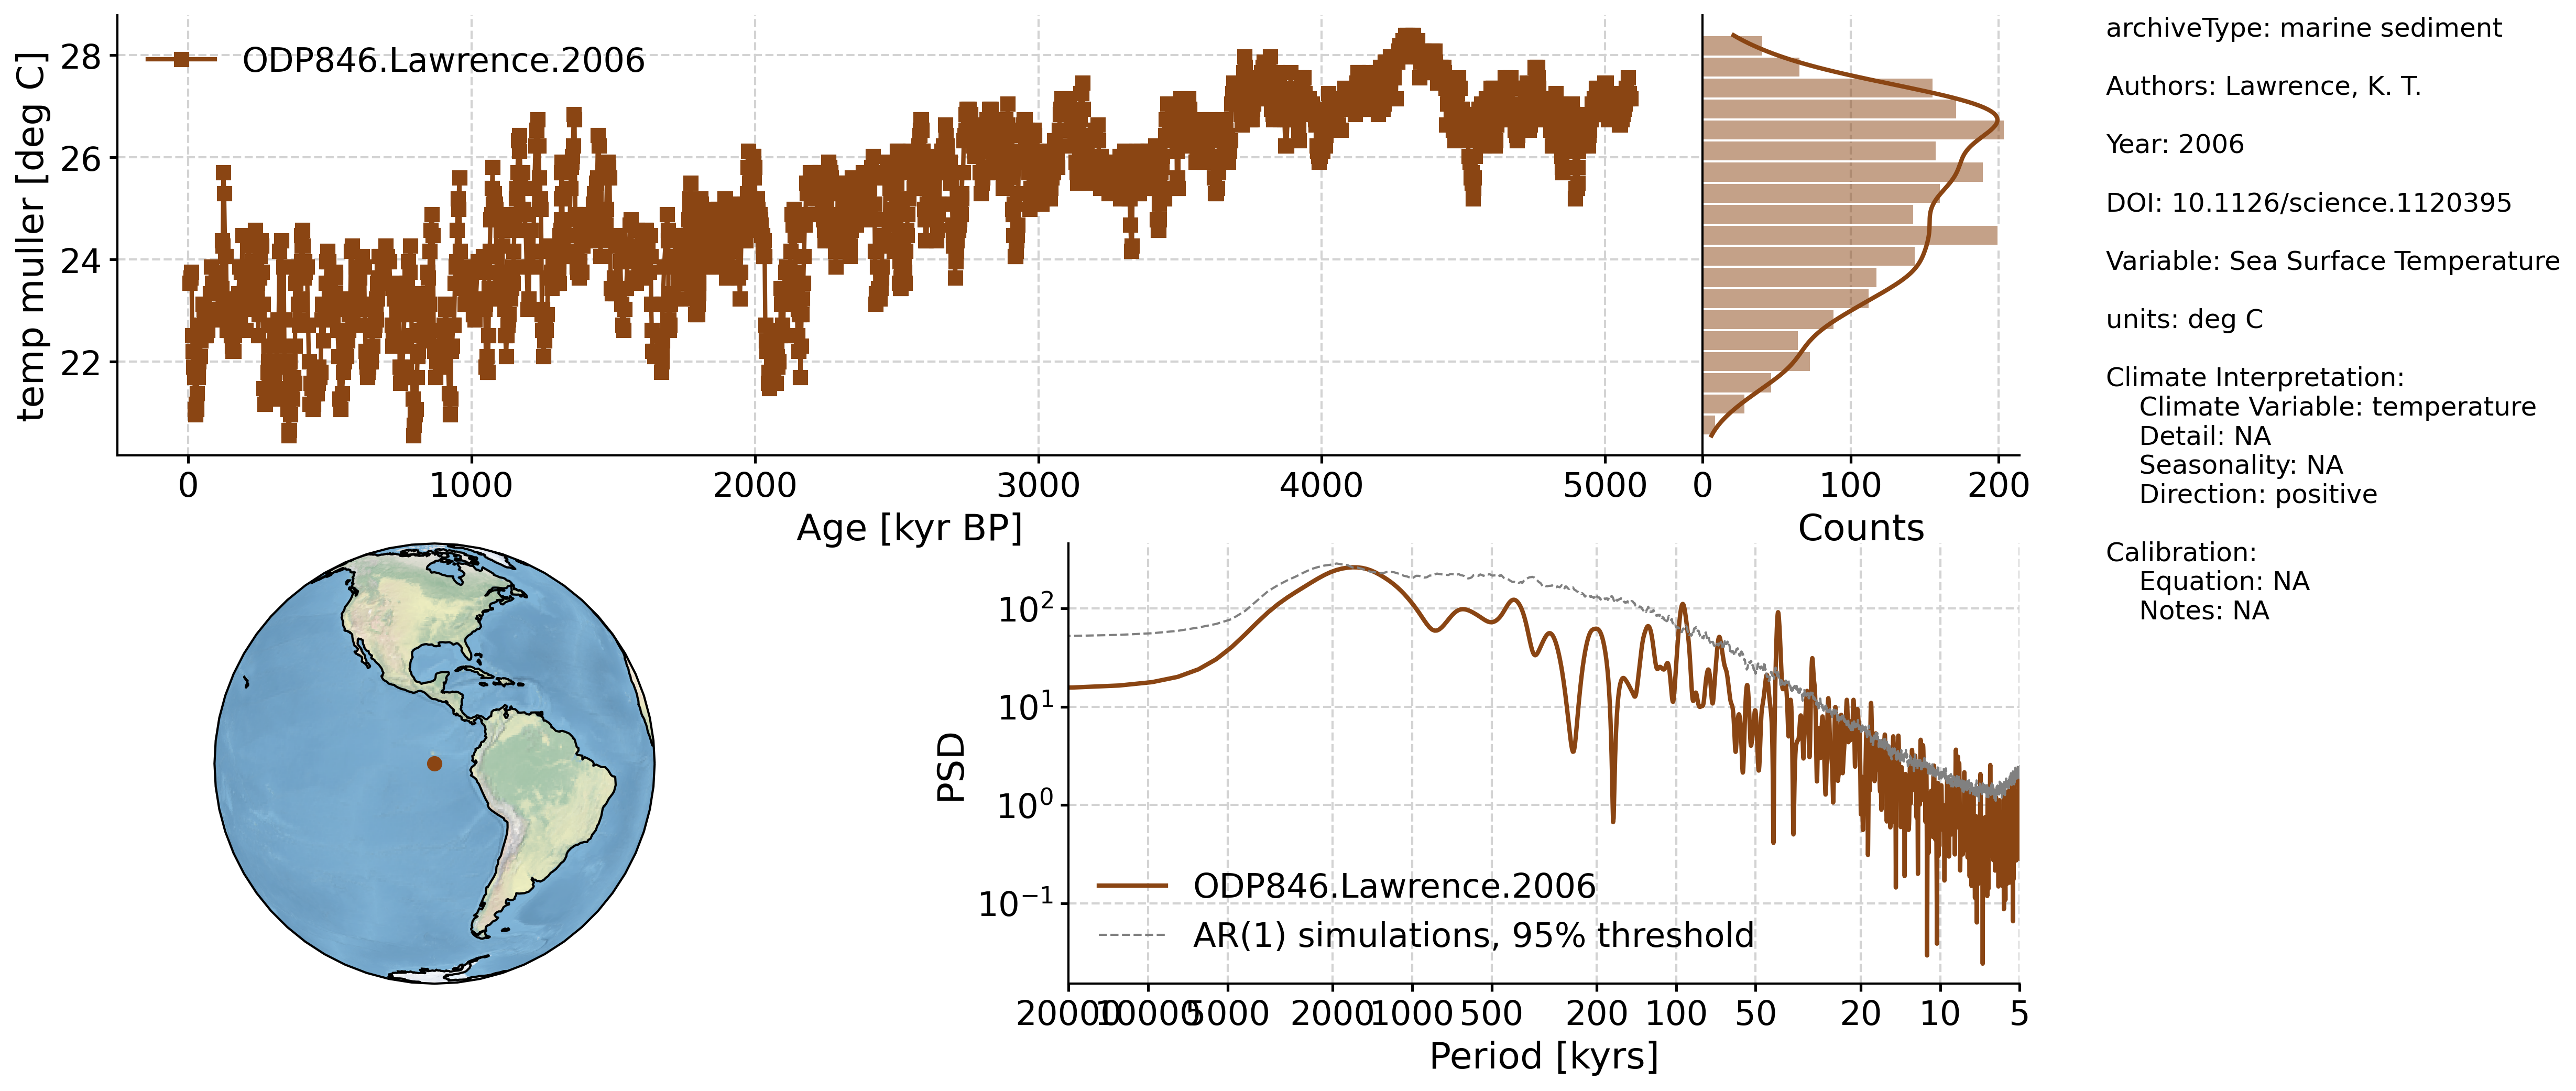

In [9]:
from IPython.display import Image

output_files = get_execution_files(exec_dashboard, ["intermediate", "output"], ["OutputPlot"]) #Name must match the name of the output file on the abstract workflow
Image(output_files['OutputPlot'])

Preliminary spectral analysis of this record shows peak at ~40kyr and ~100ky, consistent with orbital cyclicities, specifically obliquity and eccentricity.

## Spectral Analysis

Let's fecth the results from the spectral analysis workflow:

In [10]:
execs = execution_api.list_executions_by_page(pattern="SpectralAnalysis*")

Apply a start and end time for the analysis of interests:

In [11]:
start_string = "12/14/2022 10:38:00-08:00" #Date and Time of the start of the runs, -08:00 accounts for PST timezone
start = time.mktime(datetime.datetime.strptime(start_string, '%m/%d/%Y %H:%M:%S%z').timetuple()) #convert to datetime

end_string = "12/16/2022 06:00:00-08:00"
end = time.mktime(datetime.datetime.strptime(end_string, '%m/%d/%Y %H:%M:%S%z').timetuple()) #convert to datetime

Get a list of all the executions within that time frame:

In [12]:
full_execs = []
if execs["success"]:
    for ex in execs["rows"]:
        runid = ex["id"].split("#")[1]
        status = ex["runtimeInfo"]["status"]
        startTime = ex["runtimeInfo"]["startTime"]
        if status == "SUCCESS" and startTime >= start and startTime <= end:
            #print(str(len(full_execs) + 1) + ". Run id: " + runid)
            exec = execution_api.get_run_details(runid)
            full_execs.append(exec)

Next, let's create a dataframe that will contains the parameters used for the execution, the name of the executable component (e.g., linear vs sline interpolation), and a link to the data files (all files are saved in the *data* folder created in previous steps). Specfically, we will retain the files corresponding to the following outputs:

- OutputTS7: The results from the detrending step
- OutputTS8: The results of the removing outlier step
- ClusterPlot: The figures containing the clustering results
- OutputTS9: The results from the regridding steps to an evenly-spaced time axis
- OutputPSDSig: The results of the spectral analysis, with significance. 

In [91]:
df = None
all_rows = []
for exec in full_execs:
    steps = exec["execution"]["plan"]["steps"]
    cvalues = {}
    for step in steps:
        cname = step["codeBinding"]["codeDirectory"].split("/")[-1]
        cvalues[cname] = True

    params = get_execution_parameters(exec)
    input_files = get_execution_files(exec, ["input"], ["InputTS"])
    output_files = get_execution_files(exec, ["intermediate", "output"], ["OutputTS7", "OutputTS8","ClusterPlot","OutputTS9","OutputPSD","OutputPSDSig"])

    row = dict(params)
    row.update(input_files)
    row.update(output_files)
    row.update(cvalues)

    if df is None:
        df = pd.DataFrame()
    
    df = pd.concat([df, pd.DataFrame([row])], ignore_index=True)

df.head()

adaptive max_clusters start    NW  step windowLength deriv polyorder    qs  \
0    false           10  -1.0  -1.0  -1.0           -1     0         2  0.95   
1      NaN           10  -1.0   NaN  -1.0           -1     0         2  0.95   
2      NaN           10  -1.0   NaN  -1.0           -1     0         2  0.95   
3      NaN           10  -1.0   NaN  -1.0           -1     0         2  0.95   
4      NaN           10  -1.0   NaN  -1.0           -1     0         2  0.95   

  remove  ... metric min_samples  eps nbr_clusters n_neighbors DBSCAN  \
0   true  ...    NaN         NaN  NaN          NaN         NaN    NaN   
1   true  ...    NaN         NaN  NaN          NaN         NaN    NaN   
2   true  ...    NaN         NaN  NaN          NaN         NaN    NaN   
3   true  ...    NaN         NaN  NaN          NaN         NaN    NaN   
4   true  ...    NaN         NaN  NaN          NaN         NaN    NaN   

  DetrendLinear NoDetrending    n DetrendEMD  
0           NaN          NaN  NaN        NaN  
1           NaN          NaN  NaN        NaN  
2           NaN          NaN  NaN        NaN  
3           NaN          NaN  NaN        NaN  
4           NaN          NaN  NaN        NaN  

[5 rows x 72 columns]

Available columns for querying:

In [92]:
df.columns

Index(['adaptive', 'max_clusters', 'start', 'NW', 'step', 'windowLength',
       'deriv', 'polyorder', 'qs', 'remove', 'BW', 'jackknife', 'threshold',
       'freq_method', 'h', 'mode', 'low_bias', 'TSID', 'number', 'eval',
       'sides', 'seed', 'step_type', 'delta', 'nbr_cluster', 'stop', 'InputTS',
       'OutputPSD', 'OutputTS7', 'OutputTS8', 'OutputTS9', 'ClusterPlot',
       'OutputPSDSig', 'DetrendSG', 'gkernel', 'MTM', 'kmeans', 'AR1sim',
       'standardize', 'loadJSON', 'window', 'average', 'n50', 'LombScargle',
       'scaling', 'nfft', 'return_onesided', 'Periodogram', 'nperseg',
       'noverlap', 'Welch', 'mother', 'pad', 'cwt-psd', 'nproc', 'c', 'Neff',
       'wwz-psd', 'extrapolate', 'SplineInterpolation', 'LinearInterpolation',
       'bin', 'metric', 'min_samples', 'eps', 'nbr_clusters', 'n_neighbors',
       'DBSCAN', 'DetrendLinear', 'NoDetrending', 'n', 'DetrendEMD'],
      dtype='object')

Note that this dataframe contains information about the parameters for every method, the name of the methods themselves, and a link to the files containing the desired output. For instance, `LinearInterpolation` refers to the method of that name while `extrapolate` is a parameter for that particular method.

### Effect of pre-processing on the timeseries

Pre-processing of the timeseries can affect results of the spectral analysis. Although it is difficult a priori to estimate the impact, some processing steps should be used carefully. Here, we used three pre-processing steps that could impact the results:

- detrending
- removal of outliers
- regridding through either interpolation between missing values (linear or spline interpolation) or coarsening (binning using the median in each bin or using a Gaussian Kernel).


#### Detrending

PaleoTS contains for possible detrending options:
- LinearDetrending: PaleoTS will prevent the use of this option is the trend cannot be considered linear. Since all executions succeeded, we can assume that this option was chosen by PaleoTS
- Empiral Mode Decomposition
- Fitting with a Savitzy-Golay filter and removing the low-pass filter from the series
- No detrending: no removal of trends

Let's collect the various options:

In [15]:
detrended_output = df['OutputTS7'].unique()
detrend_opt = ['DetrendSG','DetrendLinear','NoDetrending','DetrendEMD']
res ={}
for out in detrended_output:
    idx = df[df['OutputTS7']==out].first_valid_index()
    for item in detrend_opt:
        if df[item].iloc[idx]==True:
            res[item]=df['OutputTS7'].iloc[idx]
            
res    

{'DetrendSG': 'data/OutputTS7-1eldzvuo0mjsfaau6khda3mh9.json',
 'DetrendLinear': 'data/OutputTS7-b4x95u7i66ynztoenh5wxfuc5.json',
 'NoDetrending': 'data/OutputTS7-dm33un2juiu3qrf6ij5af0ys4.json',
 'DetrendEMD': 'data/OutputTS7-2twa4cumn3s16f85aunswqw1j.json'}

(<Figure size 1000x400 with 1 Axes>,
 <AxesSubplot: xlabel='Age [kyr BP]', ylabel='temp muller [deg C]'>)

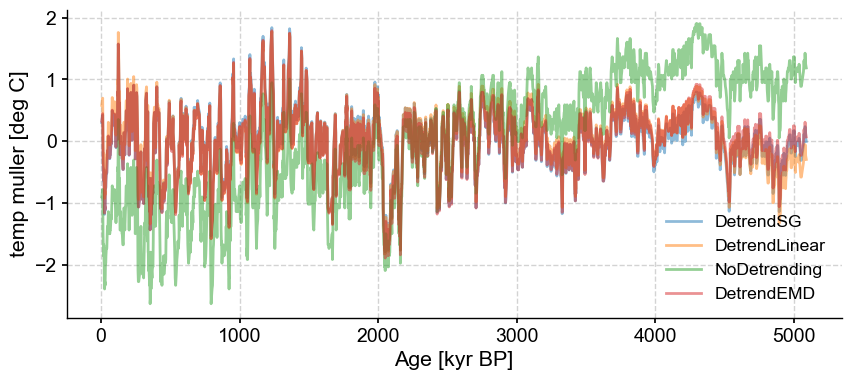

In [16]:
ts_detrend = []
for item in detrend_opt:
    ts = pyleo.utils.jsonutils.json_to_PyleoObj(res[item], 'Series')
    ts.label = item
    ts_detrend.append(ts)
    
ms = pyleo.MultipleSeries(ts_detrend)
ms.plot(plot_kwargs={'alpha':0.5})

All the detrending methods result in very similar outcomes, and there is no reason to prefer one method over the other. In the original study, the linear method was diregarded since the trend did not appear to be linear.

#### Effect of outliers

PaleoTS (via Pyleoclim) can detect and remove outliers through two clustering methods:

- DBSCAN
- kmeans

Let's examine the results from each.

##### Clustering through DBSCAN

In [44]:
files = []

for item in detrend_opt:
    outlier = df[df['DBSCAN']==True][df[item]==True][df['remove']=='true']['ClusterPlot'].unique() #note that the cluster plot will be the same reagrdless of whether the indices were subsequently removed
    files.append(outlier[0])

/var/folders/xj/p7h9764x7cx0by8547l04rrr0000gn/T/ipykernel_2804/3014215627.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  outlier = df[df['DBSCAN']==True][df[item]==True][df['remove']=='true']['ClusterPlot'].unique() #note that the cluster plot will be the same reagrdless of whether the indices were subsequently removed


Detrended with method: DetrendSG


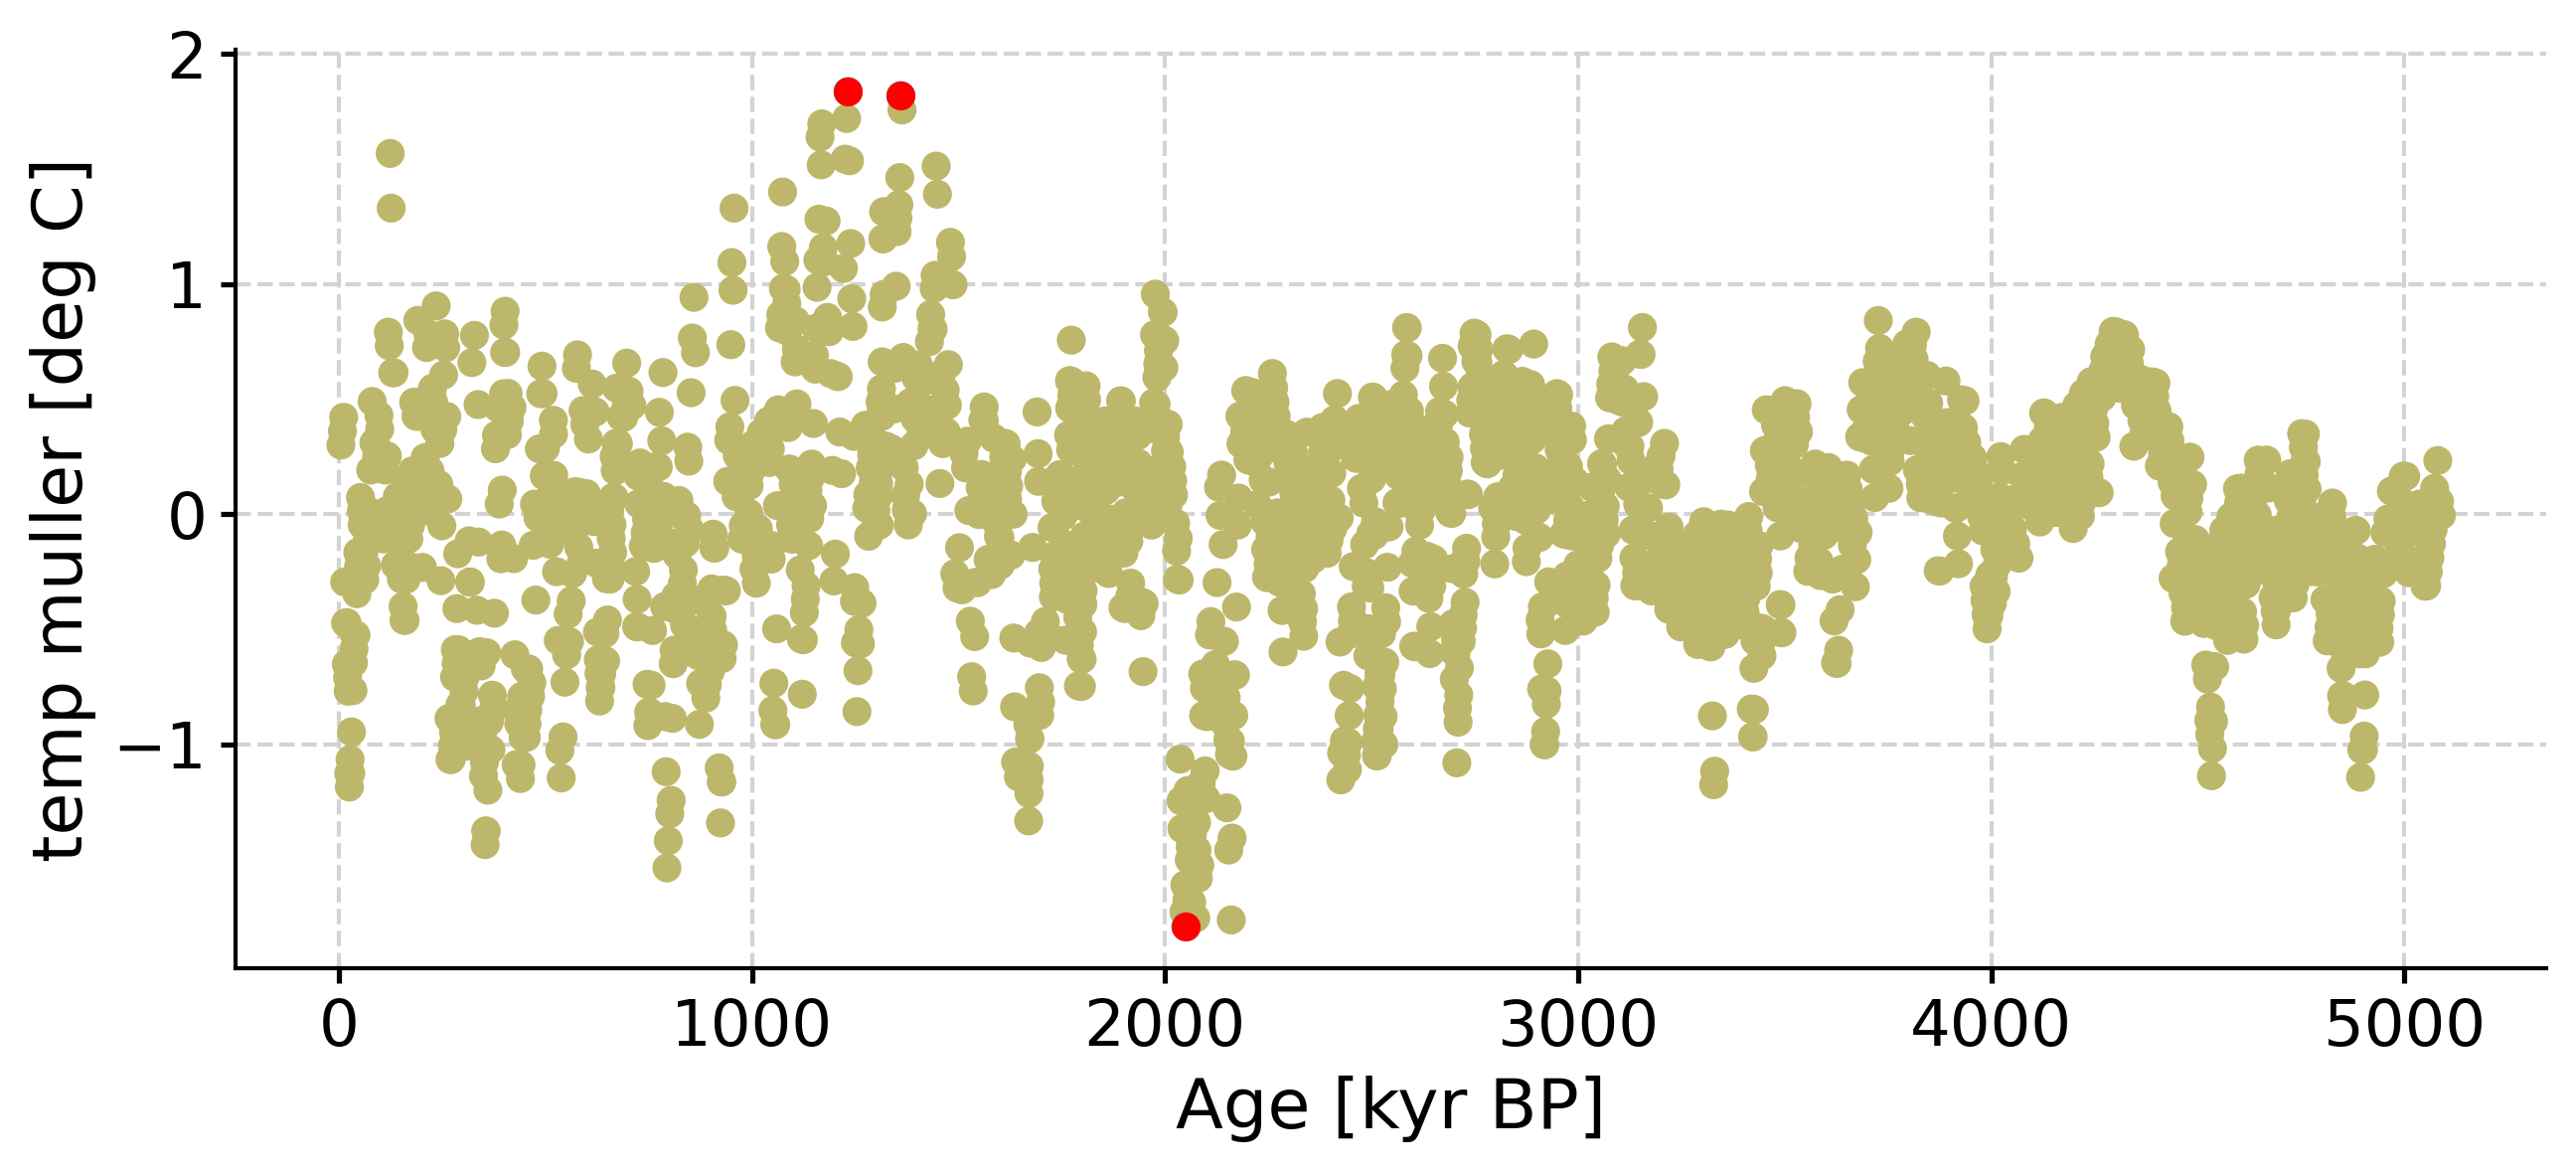

In [45]:
print("Detrended with method: "+detrend_opt[0])
Image(files[0])

Detrended with method: DetrendLinear


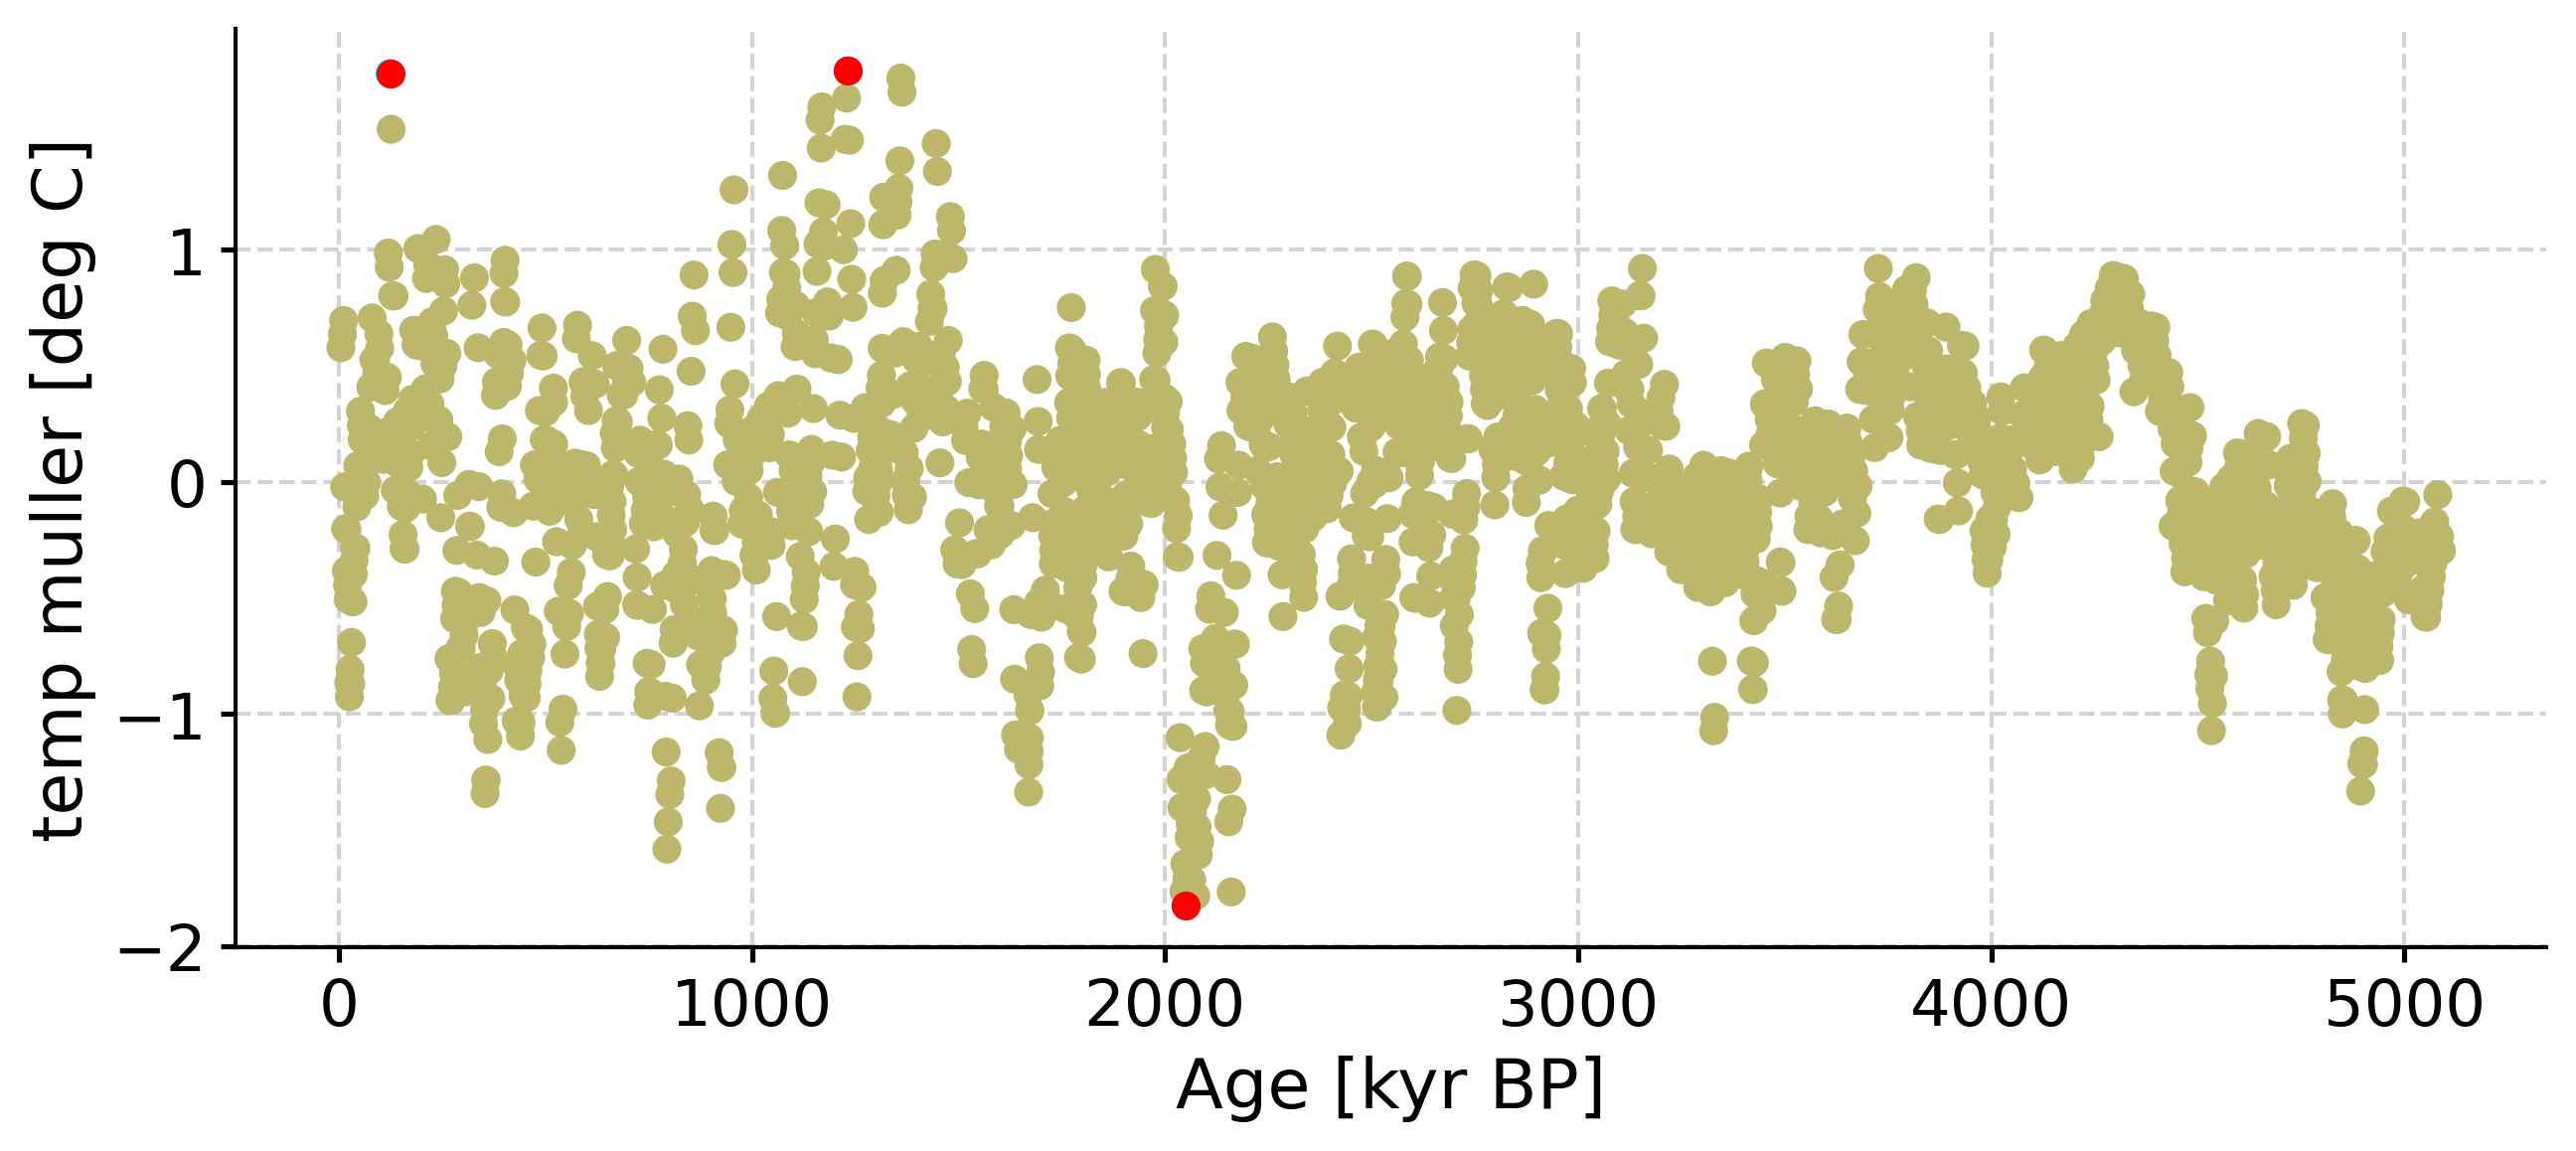

In [46]:
print("Detrended with method: "+detrend_opt[1])
Image(files[1])

Detrended with method: NoDetrending


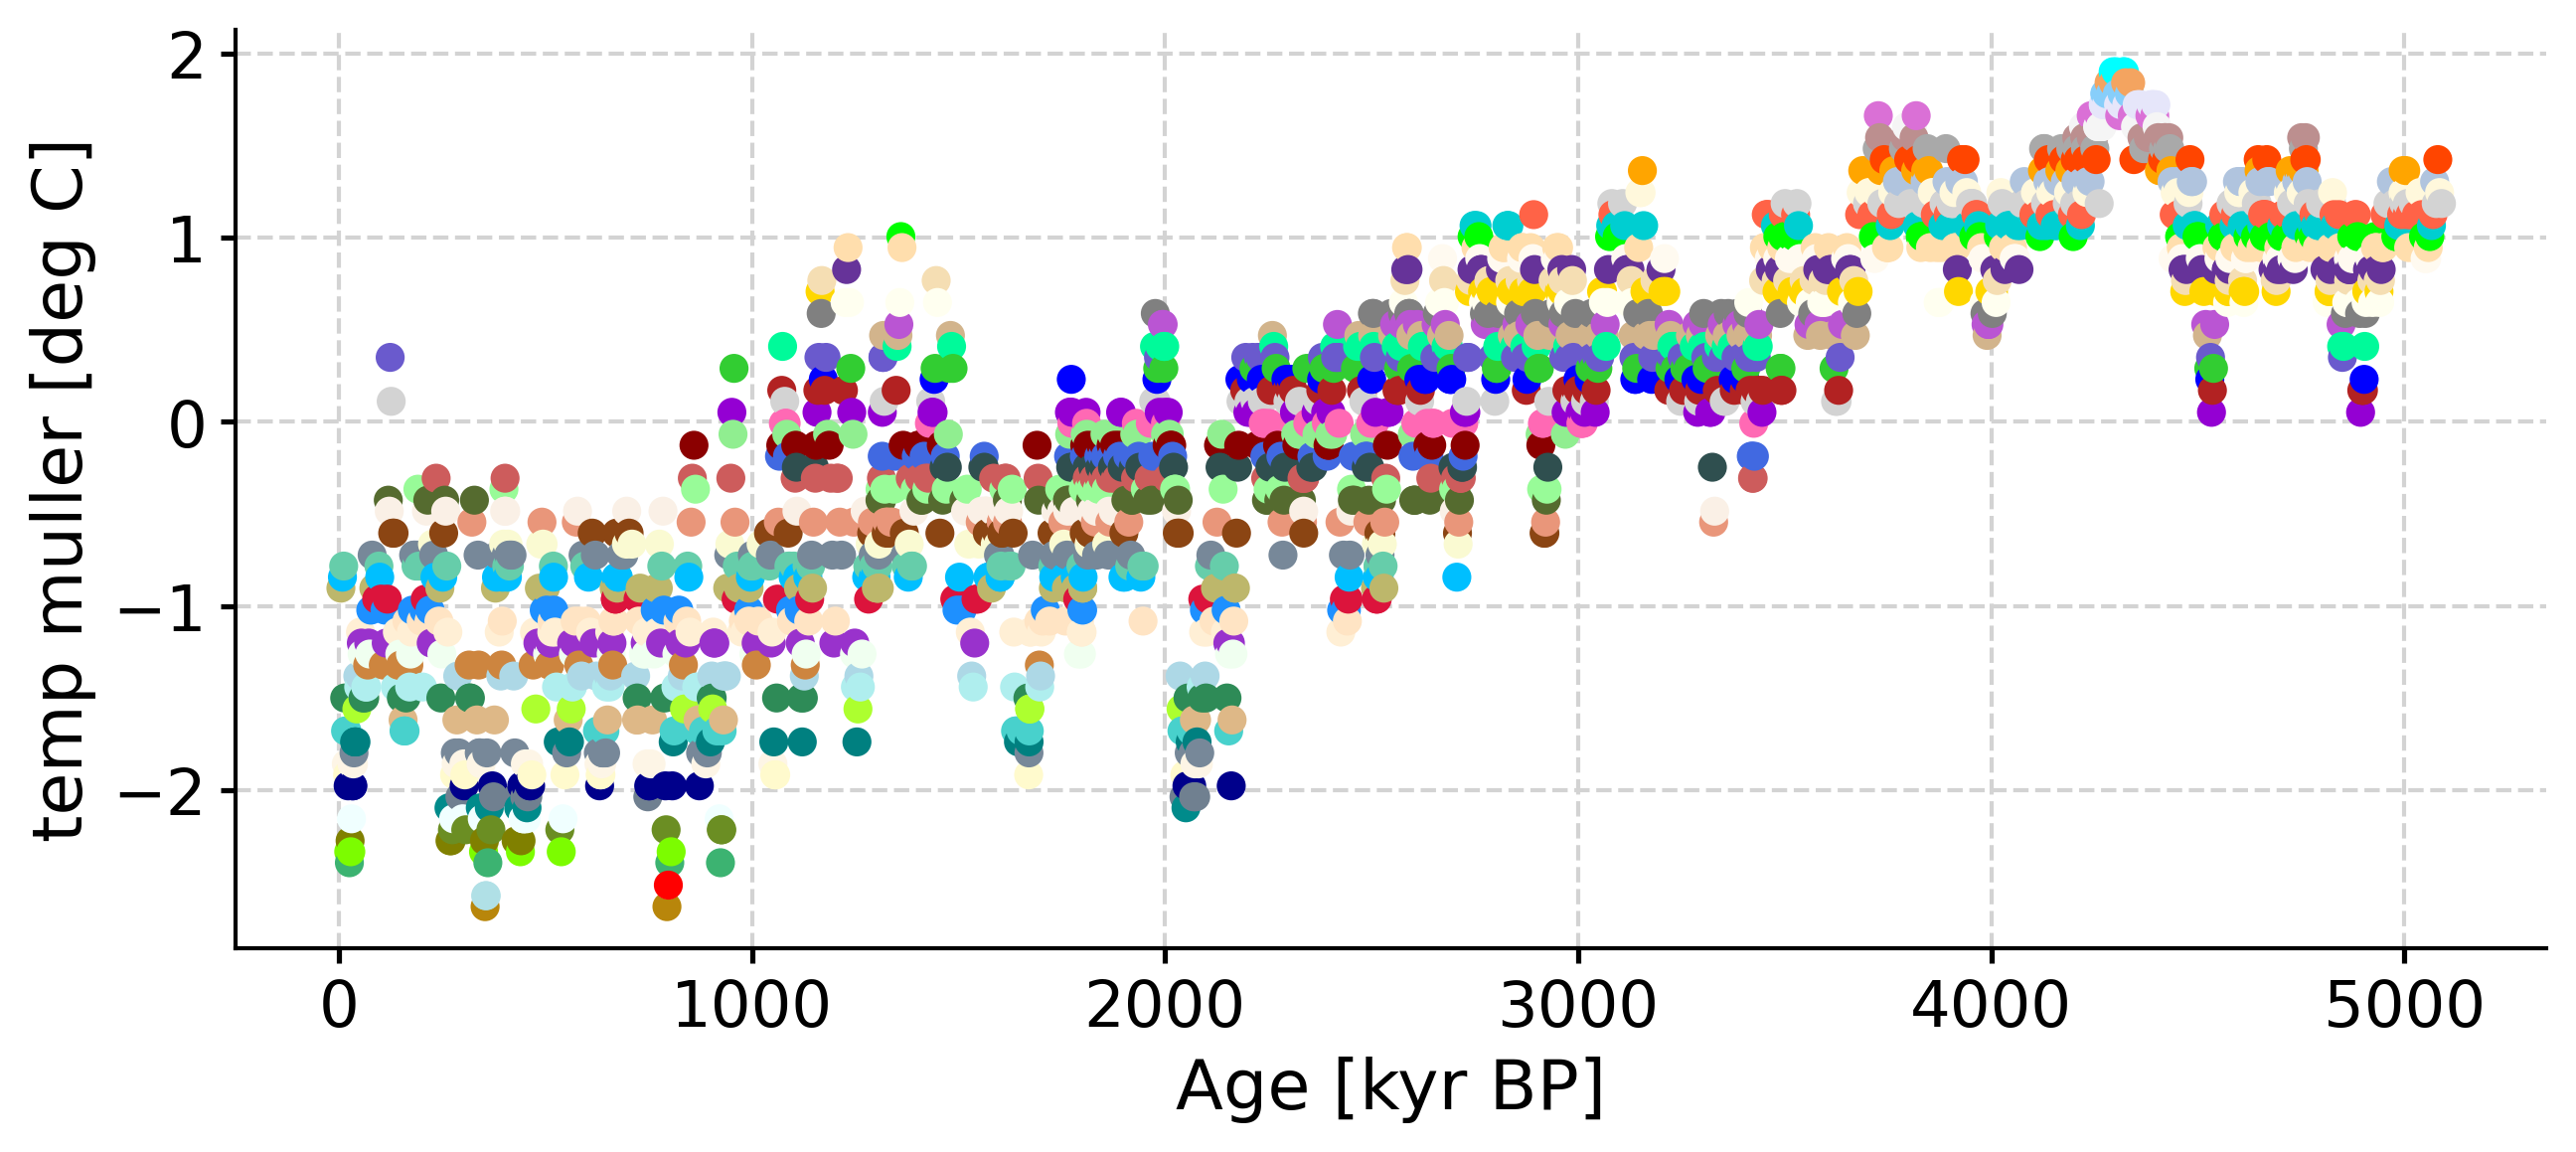

In [47]:
print("Detrended with method: "+detrend_opt[2])
Image(files[2])

Detrended with method: DetrendEMD


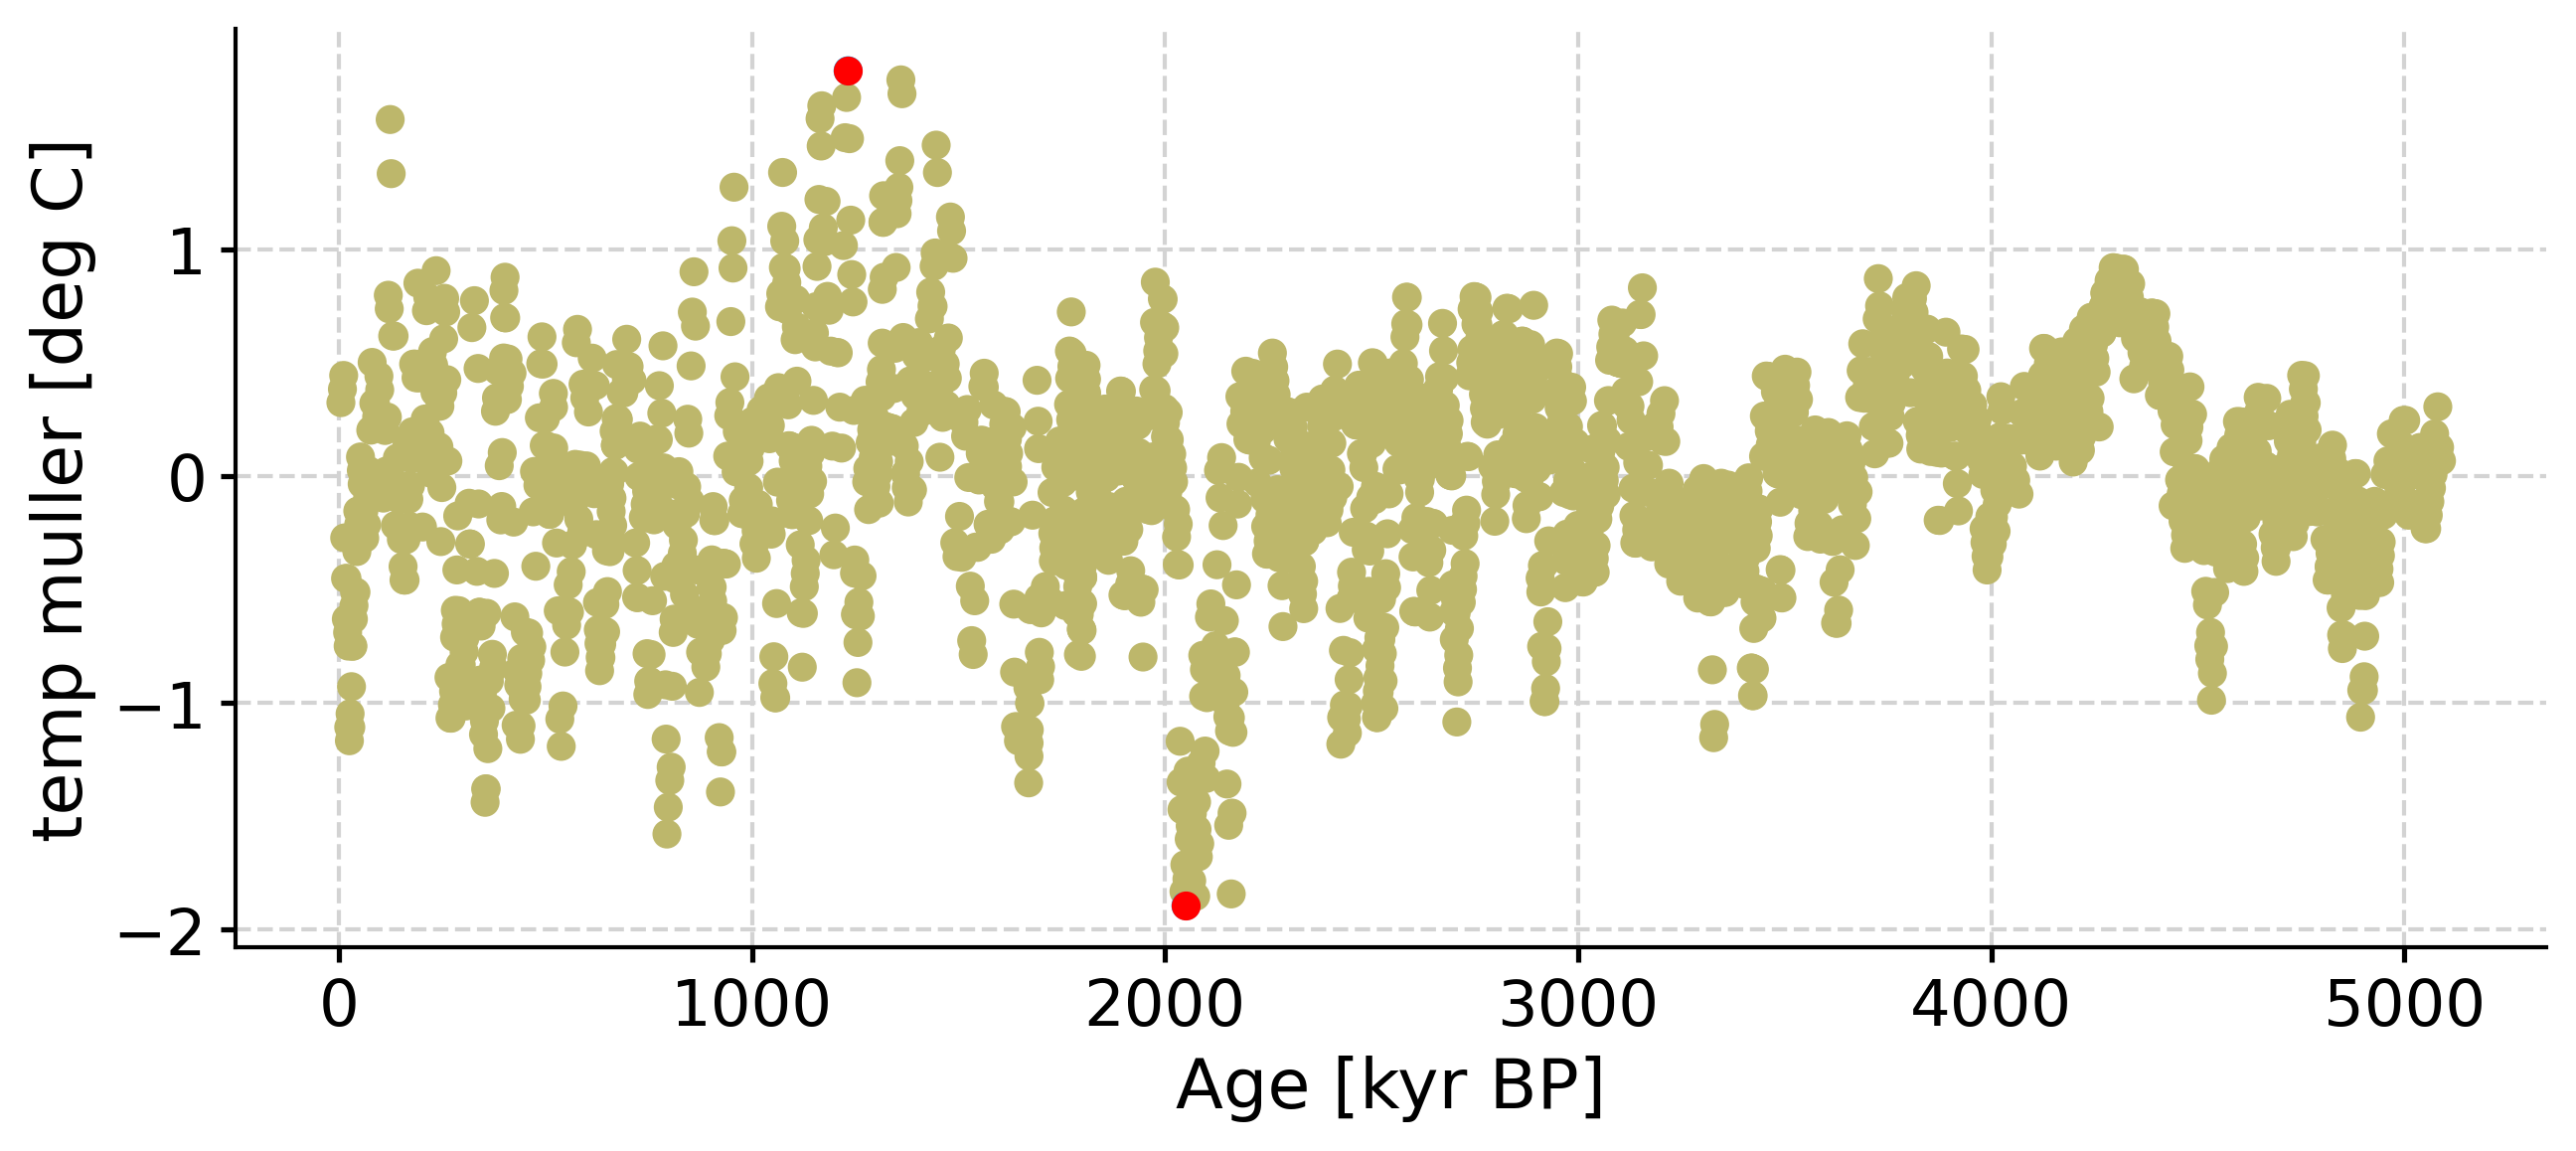

In [48]:
print("Detrended with method: "+detrend_opt[3])
Image(files[3])

With detrending not applied a priori, most cycles are detected as part of differnet clusters, and very few points result in outliers. The same is true when other detrending methods were applied before hand (in this case, most of the timeseries was considered to be within 1 cluster). The location of the outliers (very few in the series) seems to depend on the detrending option applied before hand. It doesn't seem useful to remove the 2-3 points detected by the algorithm. We ran PaleoTS with the "remove" option set as both True/False. As far as DBSCAN is concerned, let's process with the option `remove == false`.

This is consistent with visual observation of the timeseries where no outliers stand out. 

##### Clustering with kmeans

In [50]:
files = []

for item in detrend_opt:
    outlier = df[df['kmeans']==True][df[item]==True][df['remove']=='true']['ClusterPlot'].unique() #note that the cluster plot will be the same reagrdless of whether the indices were subsequently removed
    files.append(outlier[0])

/var/folders/xj/p7h9764x7cx0by8547l04rrr0000gn/T/ipykernel_2804/1248940749.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  outlier = df[df['kmeans']==True][df[item]==True][df['remove']=='true']['ClusterPlot'].unique() #note that the cluster plot will be the same reagrdless of whether the indices were subsequently removed


Detrended with method: DetrendSG


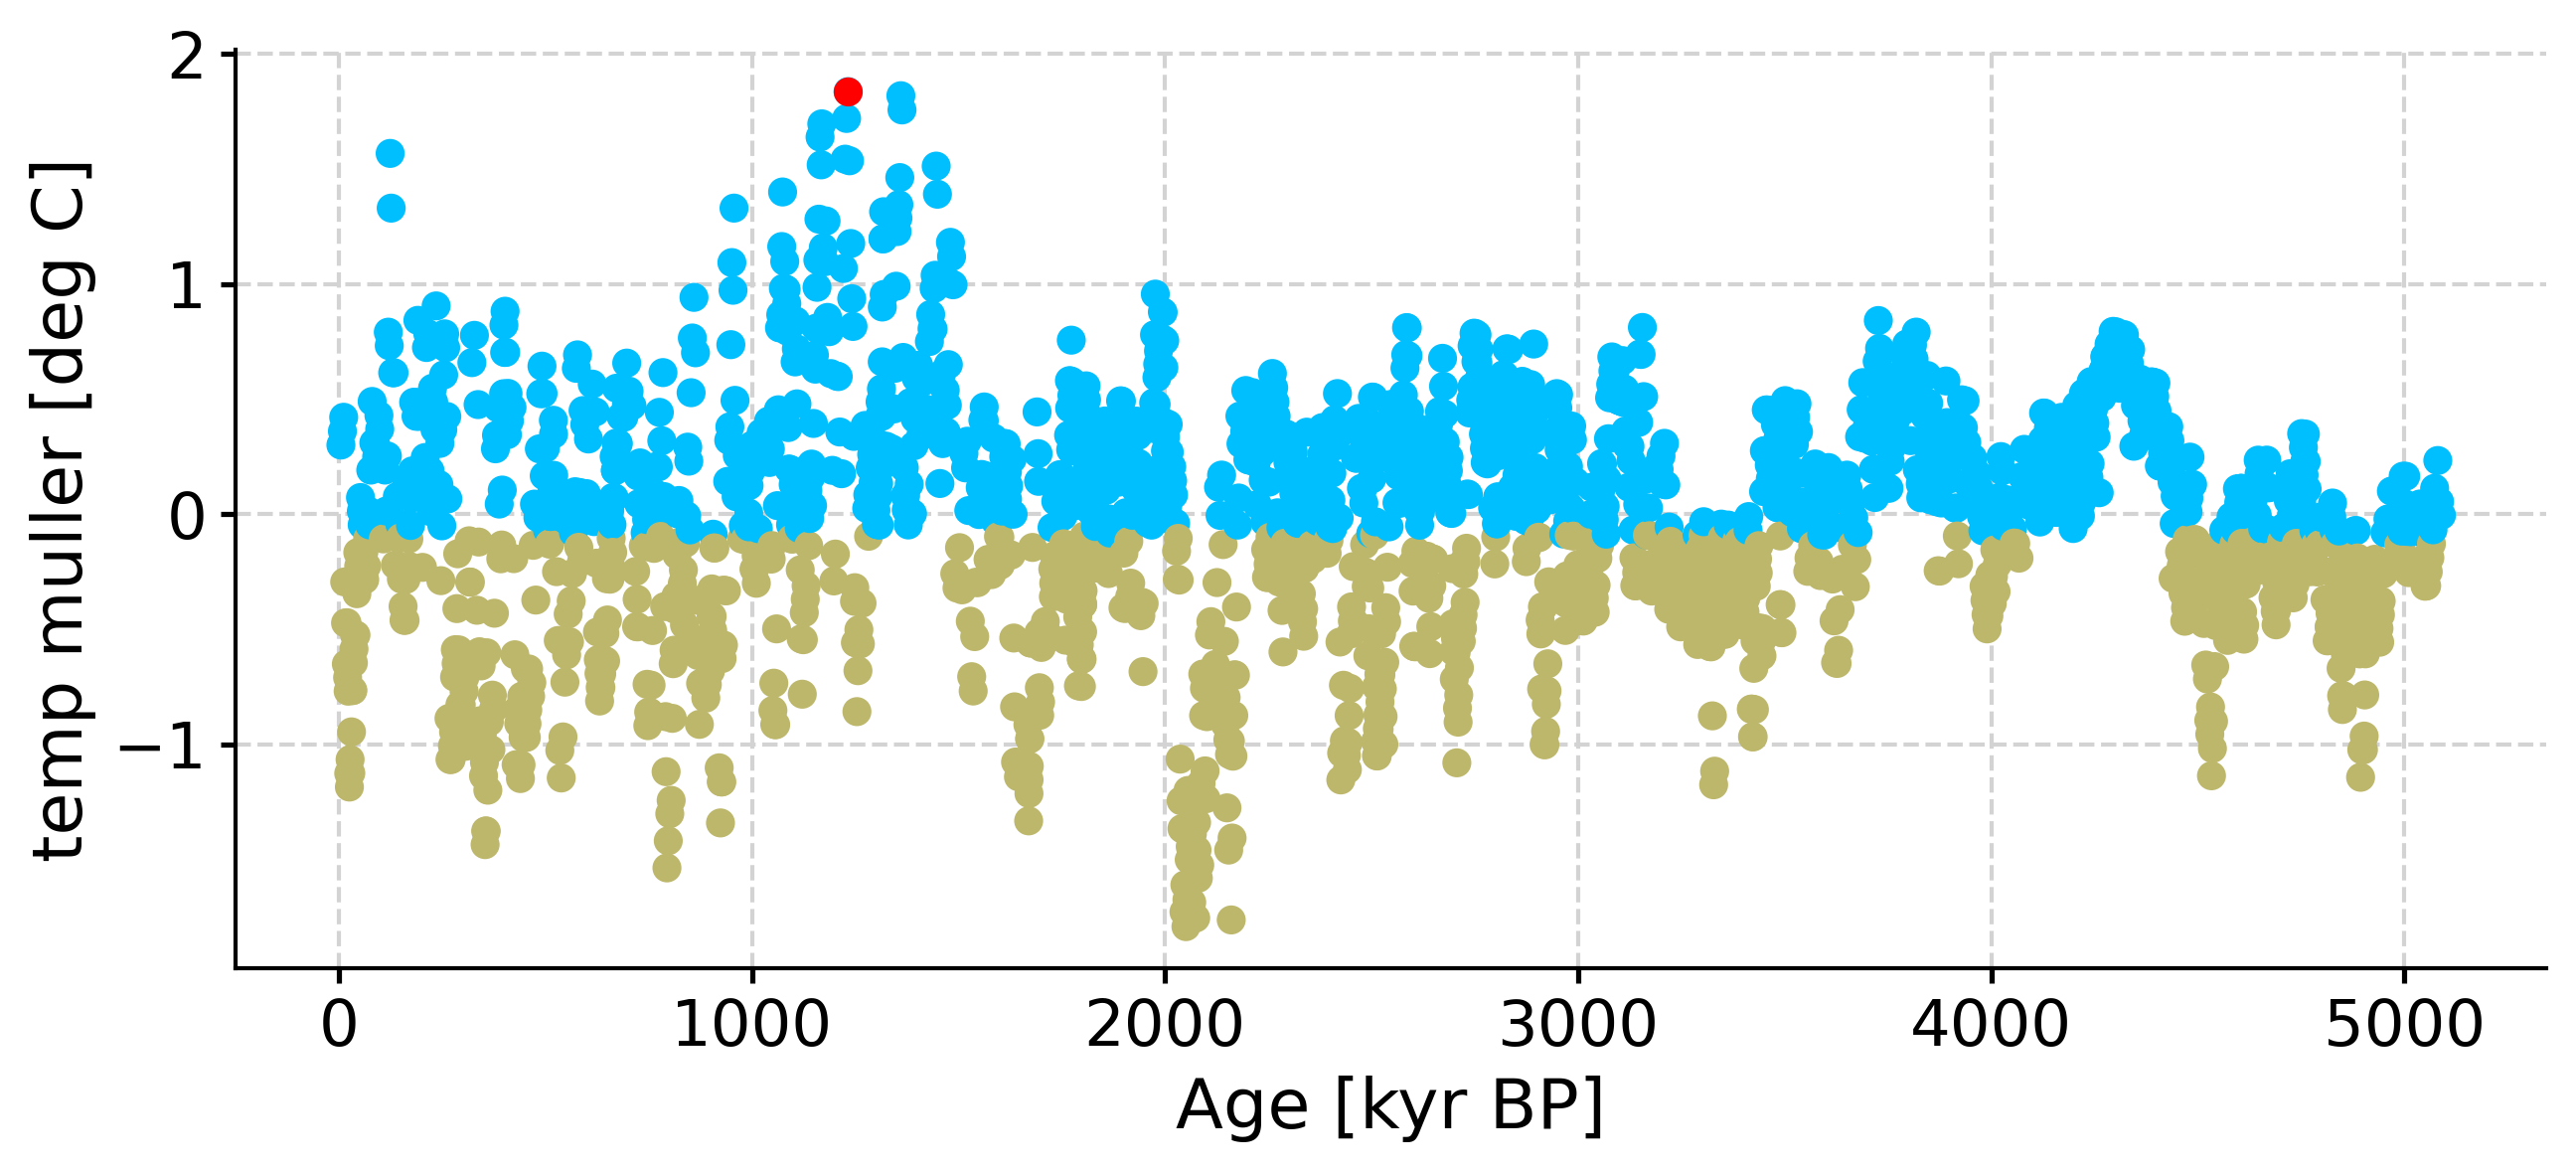

In [51]:
print("Detrended with method: "+detrend_opt[0])
Image(files[0])

Detrended with method: DetrendLinear


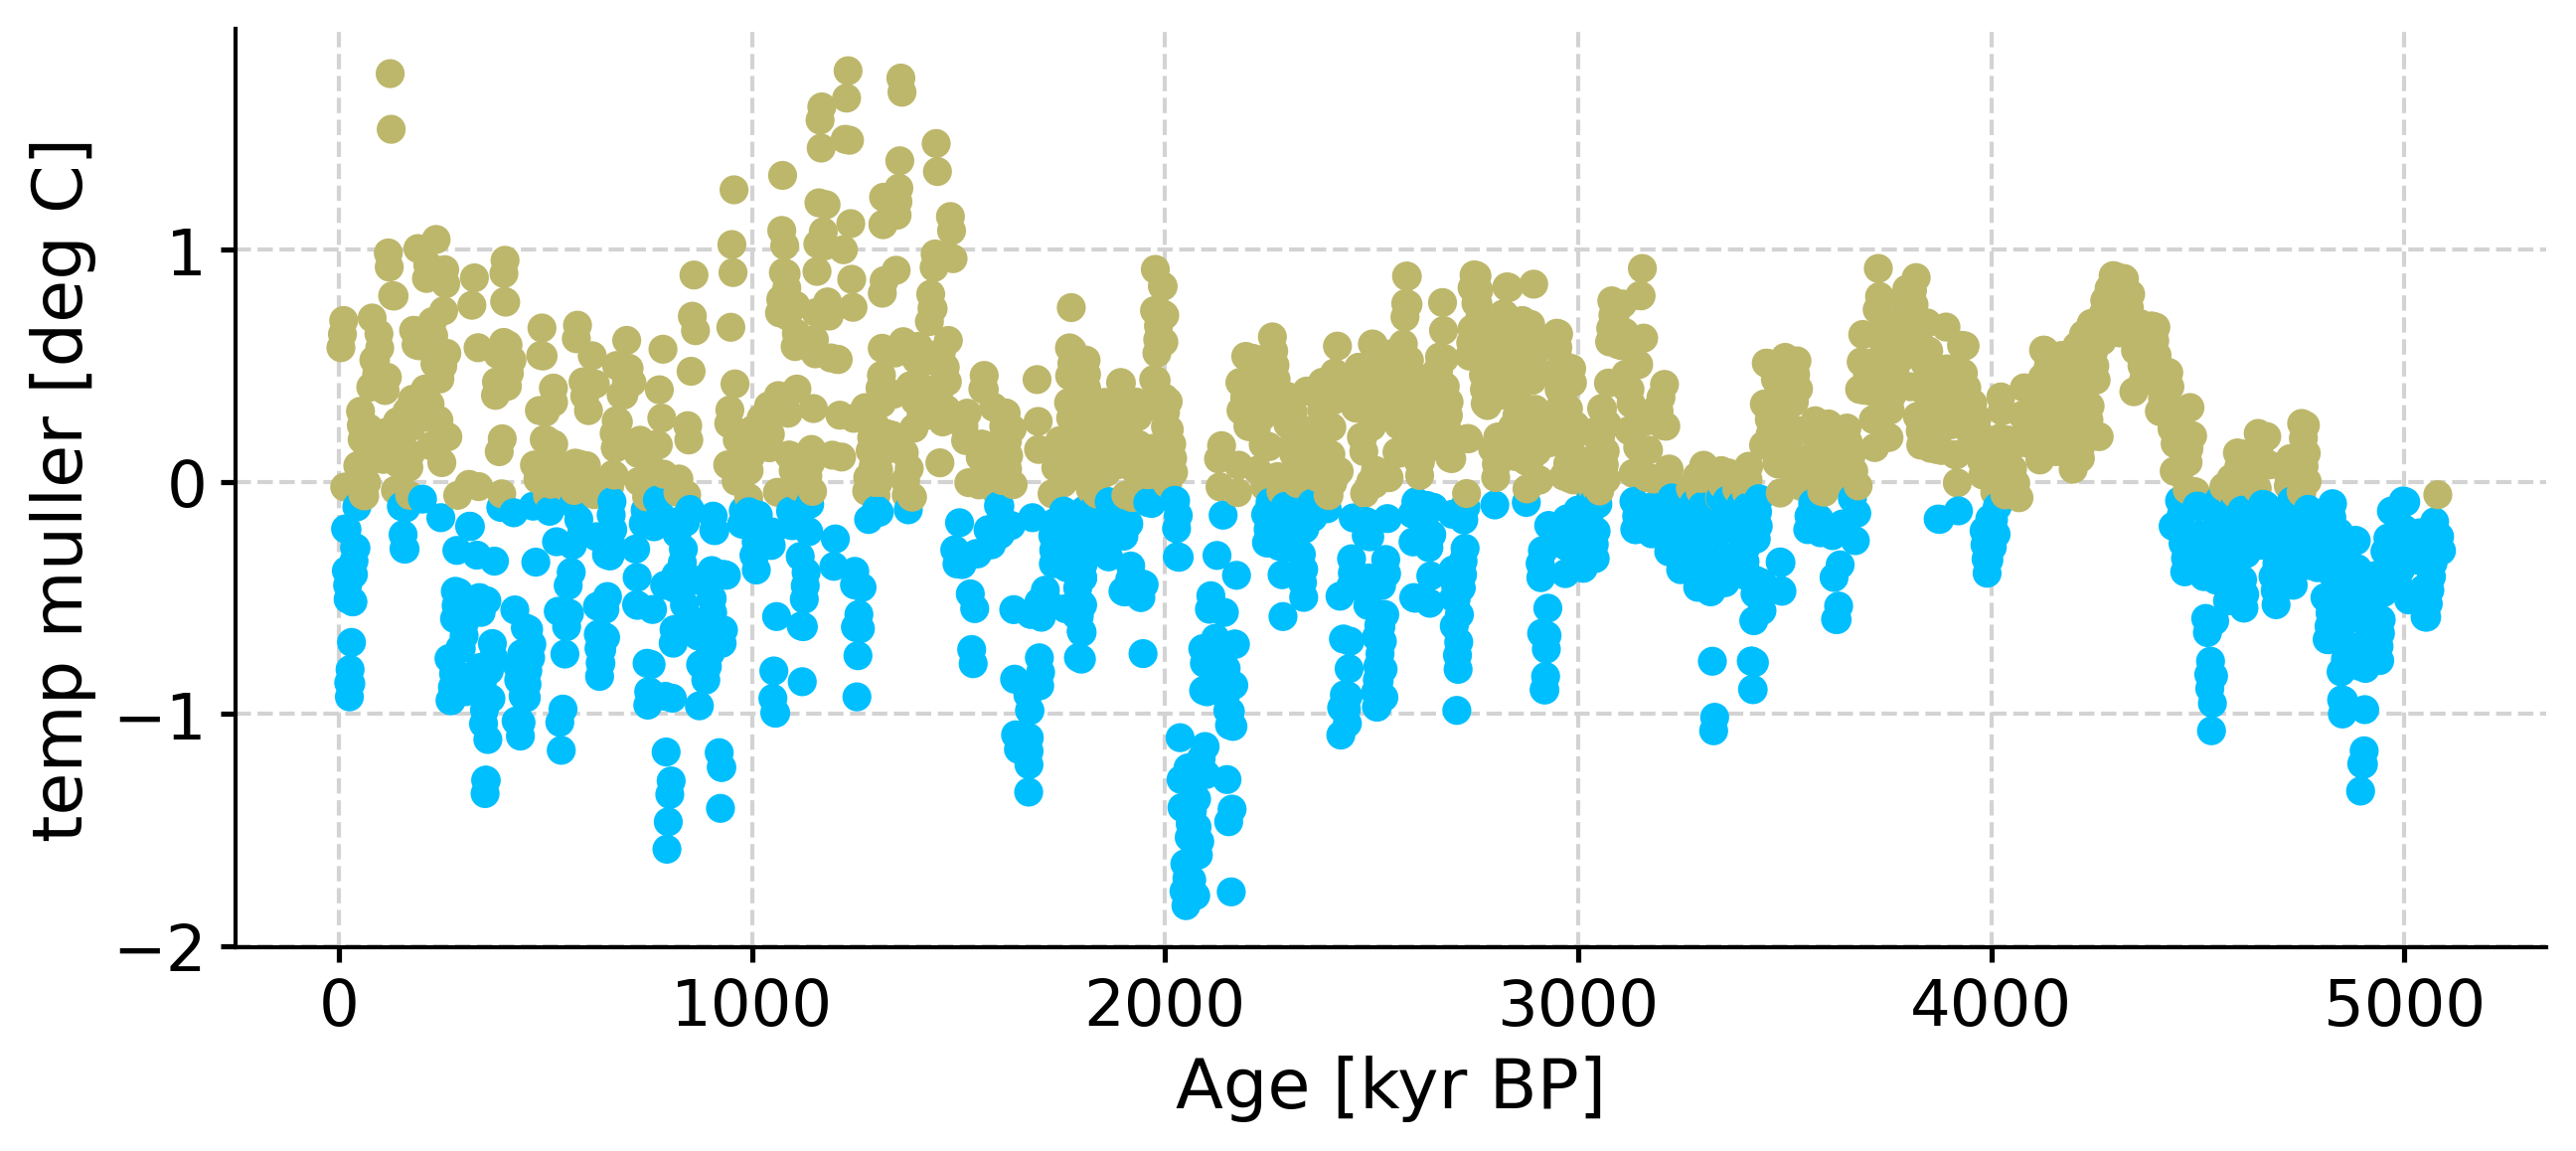

In [52]:
print("Detrended with method: "+detrend_opt[1])
Image(files[1])

Detrended with method: NoDetrending


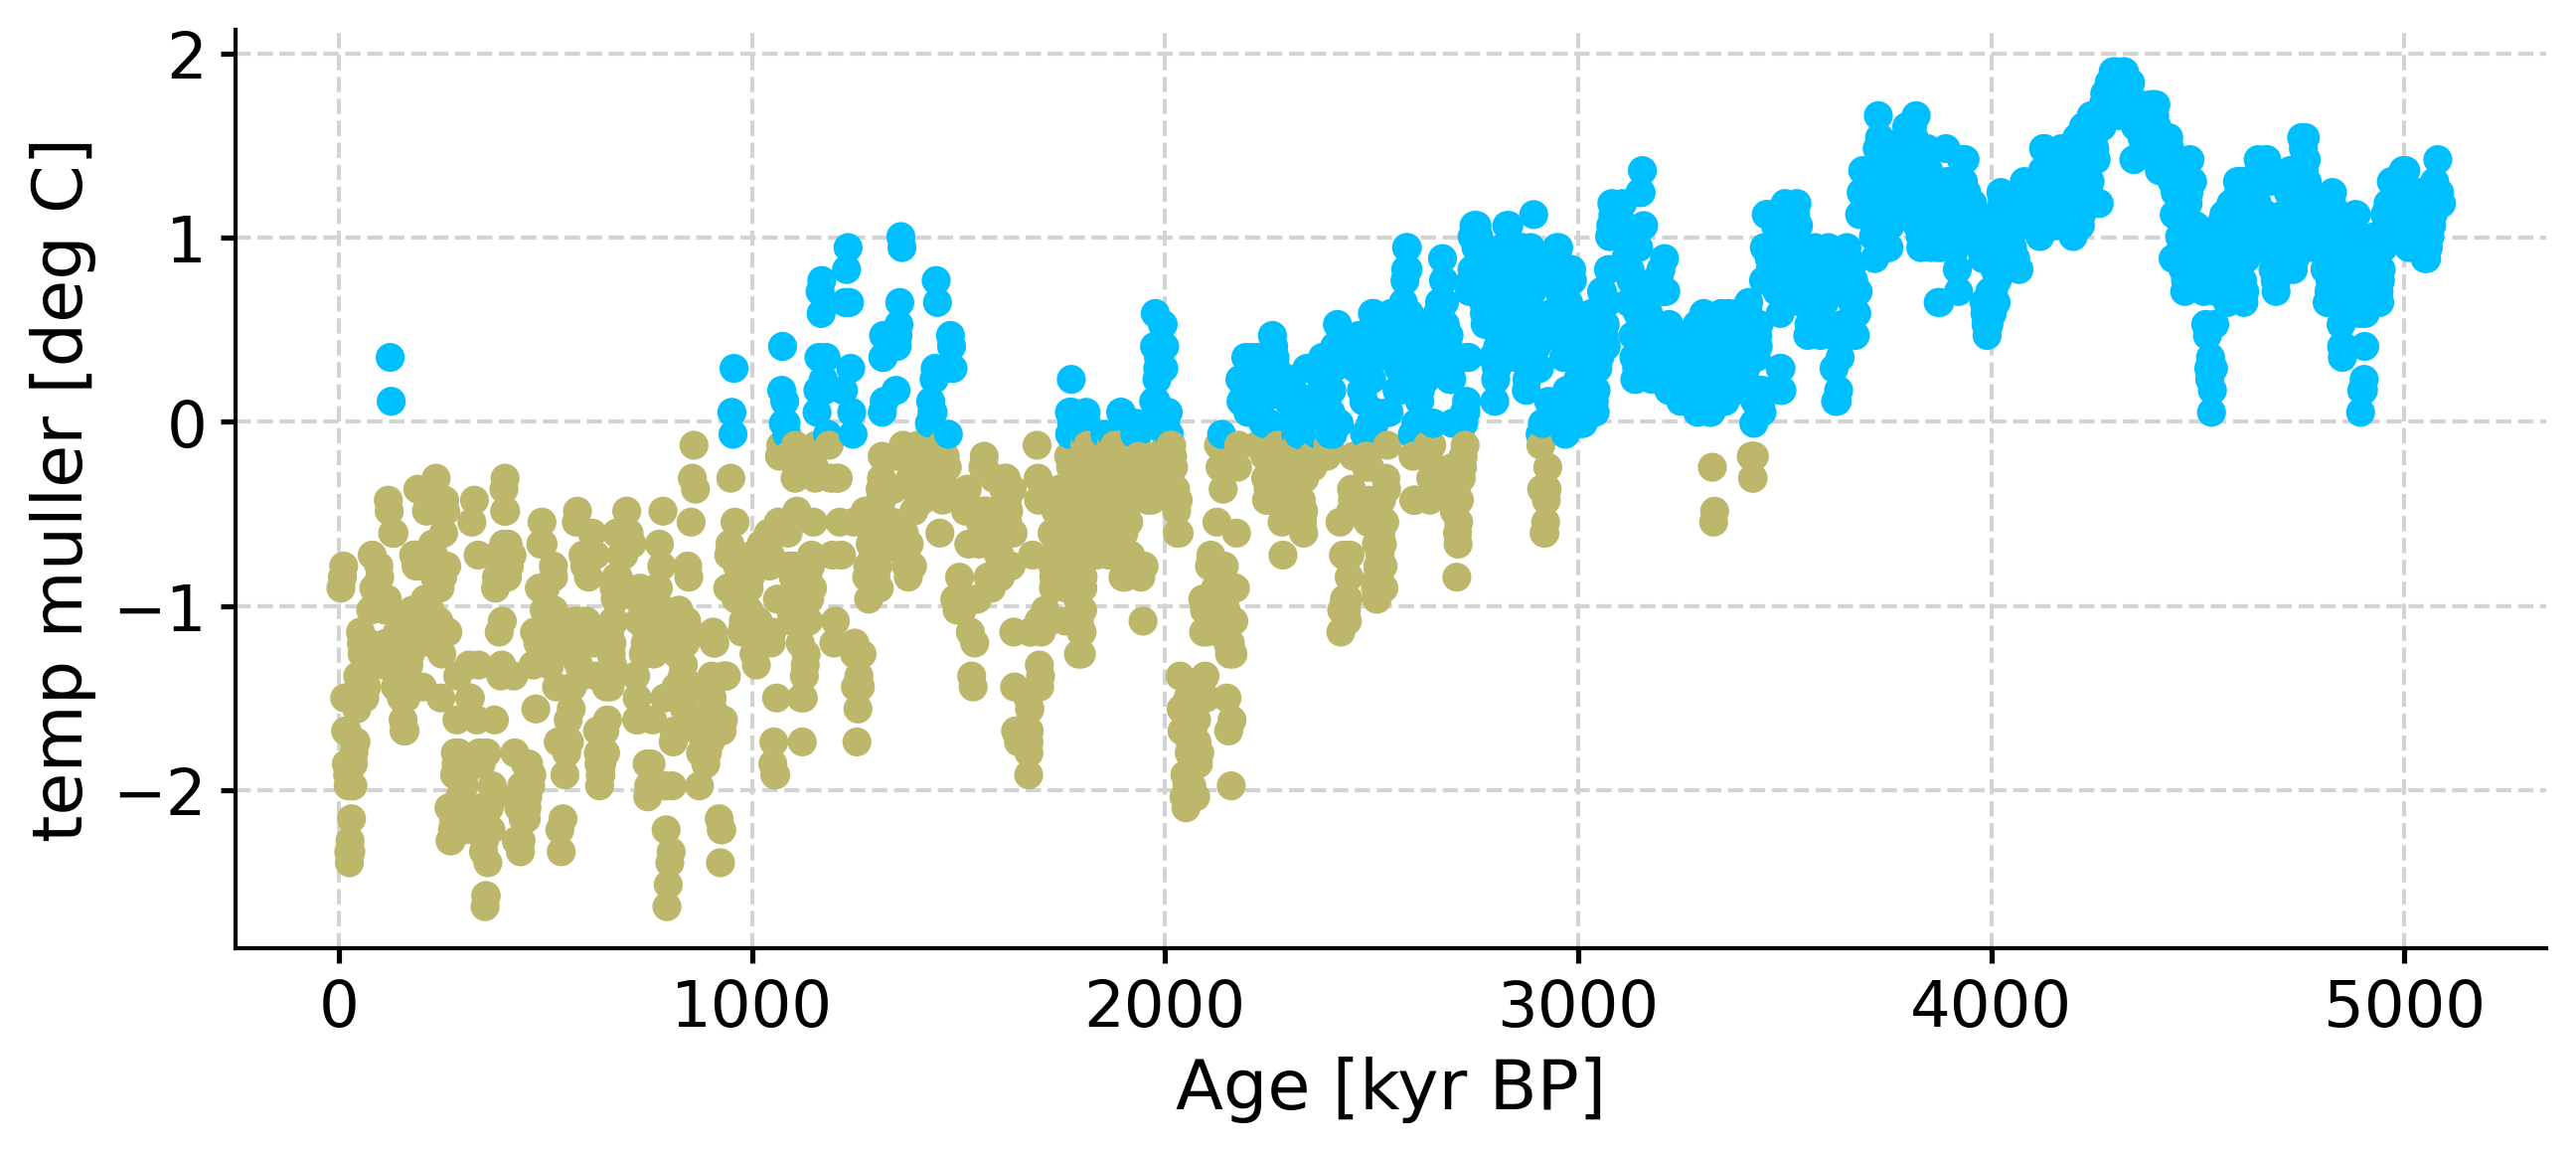

In [53]:
print("Detrended with method: "+detrend_opt[2])
Image(files[2])

Detrended with method: DetrendEMD


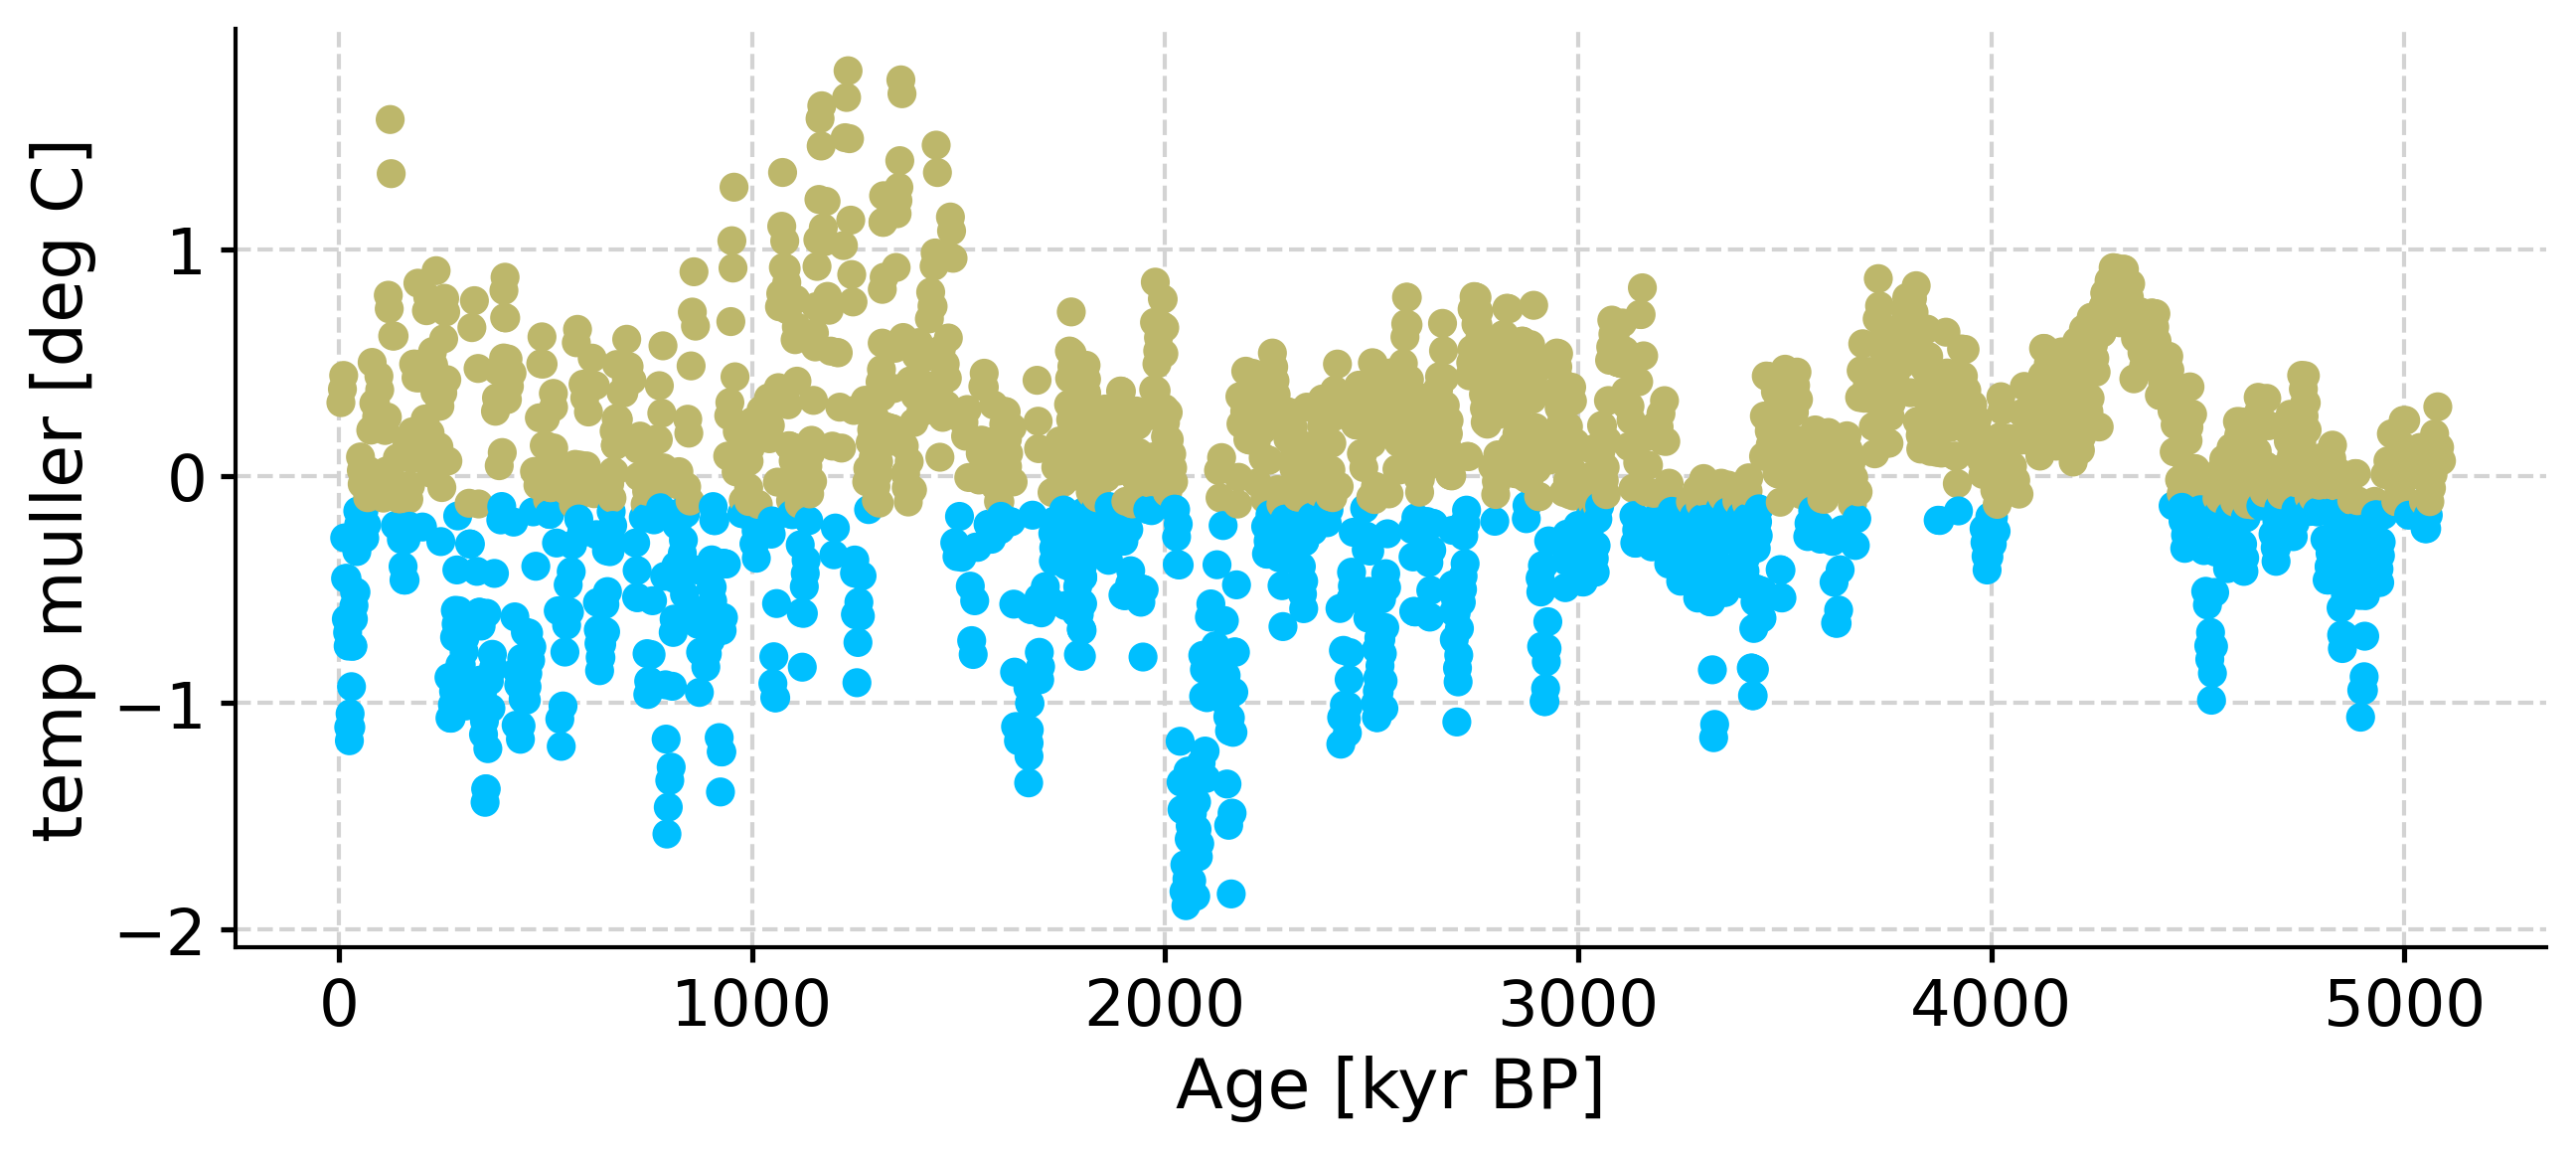

In [54]:
print("Detrended with method: "+detrend_opt[3])
Image(files[3])

With the exception of one outlier detected when the series is detrended using a Savitzy-Golay filter, no outliers are detected. This gives us confidence that keeping the results where `remove == false` is appropriate for our problem.

#### Effect of regridding

For specific spectral methods (Periodogram, Welch, and MTM), the series needs to be placed on an evenly-spaced grid in time. PaleoTS offers several options to do so:

- interpolation (which results in the creation of new data points) through linear and spline interpolation
- coarsening though binning and apply a Gaussian Kernel

Let's have a look at the timeseries after these steps. For convenience, let's concentrate on the 'EMD' detrending method (with no outlier removal; for coding purposes we will limit the search to the 'DBSCAN' method but since not data is removed in the outlier step, the two methods will result in identical outputs as far as the Series is concerned).

##### Interpolation

/var/folders/xj/p7h9764x7cx0by8547l04rrr0000gn/T/ipykernel_2804/3769497150.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  files = df[df['DBSCAN']==True][df['DetrendEMD']==True][df['remove']=='false'][df[item]==True]['OutputTS9'].unique()


(<Figure size 1000x400 with 1 Axes>,
 <AxesSubplot: xlabel='Age [kyr BP]', ylabel='temp muller [deg C]'>)

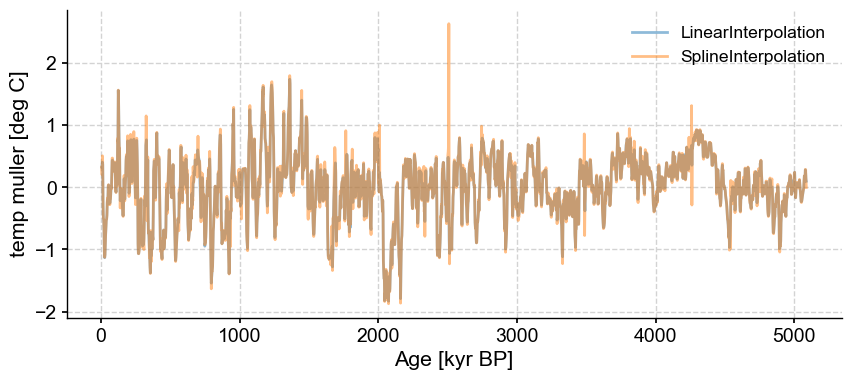

In [72]:
interp_opt = ['LinearInterpolation','SplineInterpolation']
ts_interp=[]
for item in interp_opt:
    files = df[df['DBSCAN']==True][df['DetrendEMD']==True][df['remove']=='false'][df[item]==True]['OutputTS9'].unique()
    for string in files:
        if 'TS9' in string: #ignore OutputTS9 that are direct copies of OutputTS8 if the regridding step is skipped
            ts = pyleo.utils.jsonutils.json_to_PyleoObj(string, 'Series')
            ts.label = item
            ts_interp.append(ts)

ms_interp = pyleo.MultipleSeries(ts_interp)
ms_interp.plot(plot_kwargs={'alpha':0.5})            

The spline interpolation results in some spurious data and will be ignored in further analyis. Let's investigate whether this is a problem with other interpolation steps, in this case, Savitzy-Golay:

/var/folders/xj/p7h9764x7cx0by8547l04rrr0000gn/T/ipykernel_2804/1514737376.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  files = df[df['DBSCAN']==True][df['DetrendSG']==True][df['remove']=='false'][df[item]==True]['OutputTS9'].unique()


(<Figure size 1000x400 with 1 Axes>,
 <AxesSubplot: xlabel='Age [kyr BP]', ylabel='temp muller [deg C]'>)

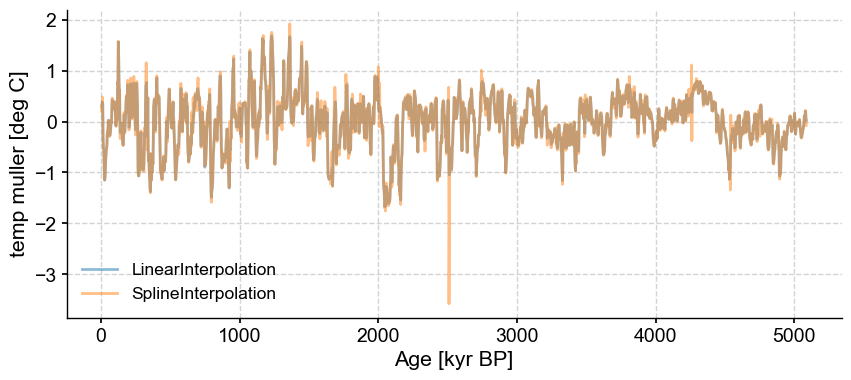

In [77]:
interp_opt = ['LinearInterpolation','SplineInterpolation']
ts_interp=[]
for item in interp_opt:
    files = df[df['DBSCAN']==True][df['DetrendSG']==True][df['remove']=='false'][df[item]==True]['OutputTS9'].unique()
    for string in files:
        if 'TS9' in string: #ignore OutputTS9 that are direct copies of OutputTS8 if the regridding step is skipped
            ts = pyleo.utils.jsonutils.json_to_PyleoObj(string, 'Series')
            ts.label = item
            ts_interp.append(ts)

ms_interp = pyleo.MultipleSeries(ts_interp)
ms_interp.plot(plot_kwargs={'alpha':0.5})            

The problem persists, although in different location.

##### Coarsening

/var/folders/xj/p7h9764x7cx0by8547l04rrr0000gn/T/ipykernel_2804/1109549466.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  files = df[df['DBSCAN']==True][df['DetrendEMD']==True][df['remove']=='false'][df[item]==True]['OutputTS9'].unique()


(<Figure size 1000x400 with 1 Axes>,
 <AxesSubplot: xlabel='Age [kyr BP]', ylabel='temp muller [deg C]'>)

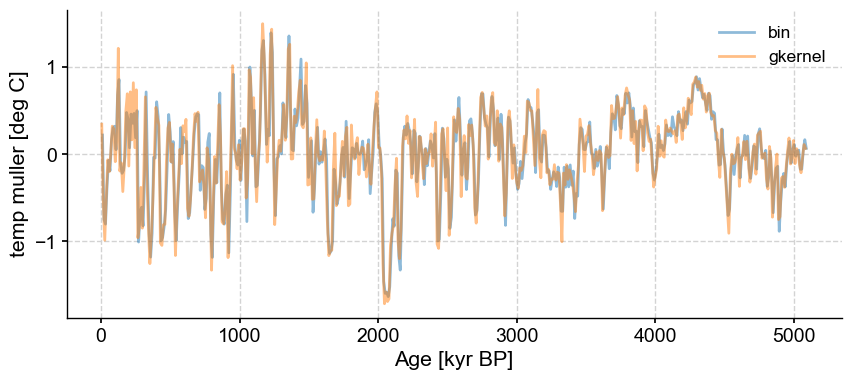

In [74]:
coarse_opt = ['bin','gkernel']
ts_coarse=[]
for item in coarse_opt:
    files = df[df['DBSCAN']==True][df['DetrendEMD']==True][df['remove']=='false'][df[item]==True]['OutputTS9'].unique()
    for string in files:
        if 'TS9' in string: #ignore OutputTS9 that are direct copies of OutputTS8 if the regridding step is skipped
            ts = pyleo.utils.jsonutils.json_to_PyleoObj(string, 'Series')
            ts.label = item
            ts_coarse.append(ts)

ms_coarse = pyleo.MultipleSeries(ts_coarse)
ms_coarse.plot(plot_kwargs={'alpha':0.5})            

Let's compare the gkernel method to the detrended output directly:

(<Figure size 1000x400 with 1 Axes>,
 <AxesSubplot: xlabel='Age [kyr BP]', ylabel='temp muller [deg C]'>)

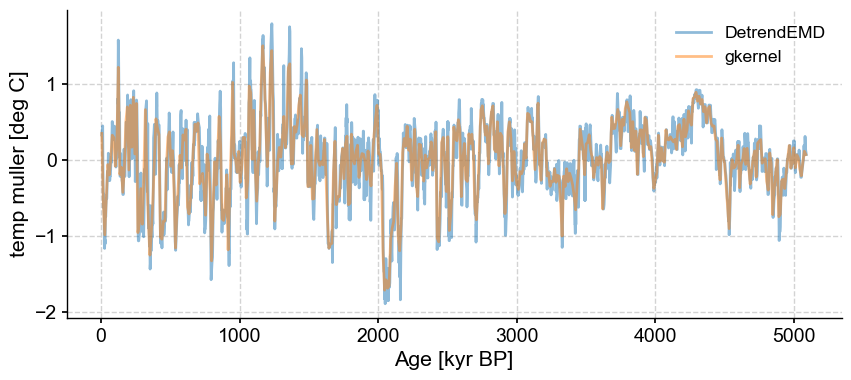

In [79]:
ms_comp = pyleo.MultipleSeries([ts_detrend[3],ts_coarse[1]])
ms_comp.plot(plot_kwargs={'alpha':0.5})

Let's do the same with binning:

(<Figure size 1000x400 with 1 Axes>,
 <AxesSubplot: xlabel='Age [kyr BP]', ylabel='temp muller [deg C]'>)

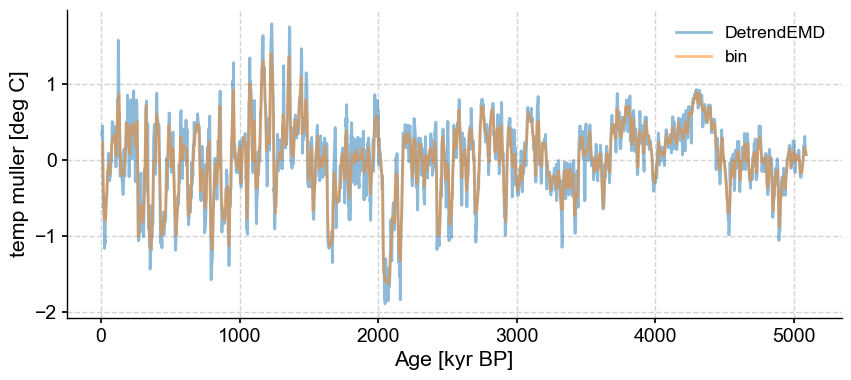

In [80]:
ms_comp = pyleo.MultipleSeries([ts_detrend[3],ts_coarse[0]])
ms_comp.plot(plot_kwargs={'alpha':0.5})

Either of the coarsening methods seems reasonable. 

### Power in the orbital band

Given the results of our sensitivity analysis on the various pre-processing methods, we will consider the following steps to investigate the impacts of the statistical methods on our conclusions:

- Detrending using the linear, Savitzy-Golay, EMD or no detrending.
- No removal of outliers
- For methods requiring regridding: linear interpolation, binning and gkernel.

#### Methods geared towards non-evenly spaced timeseries: Weighted Wavelet Z-Transform and Lomb-Scargle

##### Lomb-Scargle

In [93]:
detrend_opt = ['DetrendSG','DetrendLinear','NoDetrending','DetrendEMD']
psd_LS =[]

for item in detrend_opt:
    file = df[df['DBSCAN']==True][df[item]==True][df['remove']=='false'][df['LombScargle']==True]['OutputPSDSig'].unique()
    if len(file)>1:
        raise ValueError('Should only get one unique file from this query')
    else:
        psd=pyleo.utils.jsonutils.json_to_PyleoObj(file[0], 'PSD')
        psd.label = item
        psd_LS.append(psd)

/var/folders/xj/p7h9764x7cx0by8547l04rrr0000gn/T/ipykernel_2804/2111696200.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  file = df[df['DBSCAN']==True][df[item]==True][df['remove']=='false'][df['LombScargle']==True]['OutputPSDSig'].unique()


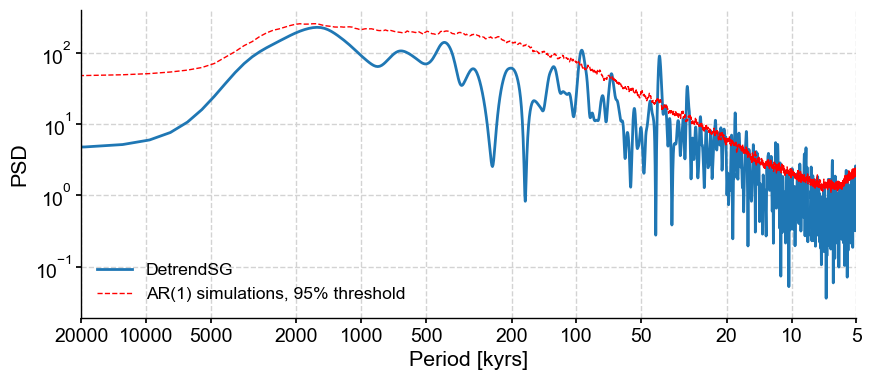

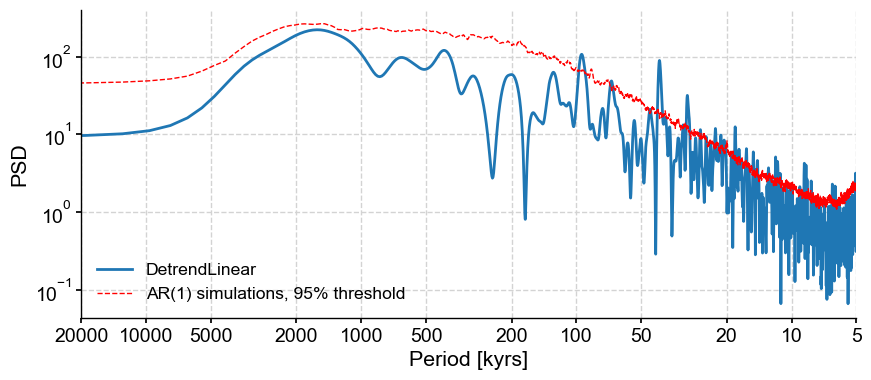

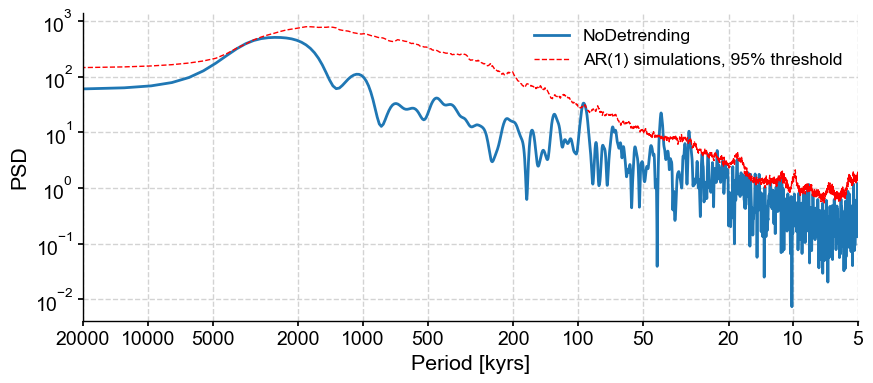

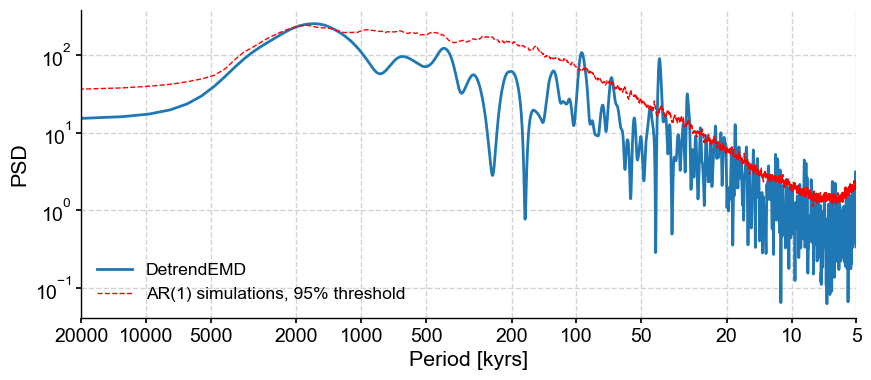

In [94]:
for psd in psd_LS:
    psd.plot()

The record displays significant periodicities around and 100 kyr and singificant peaks in the precessional and obliquity band (23-40 kyr). The singificance of these peaks is more muted when no detrending was applied prior to spectral analysis, which is not suprising given the large long-term trend in the data, resulting in more power in frequencies lower than orbital cyclicities.

##### Wavelet Z Transform

In [95]:
detrend_opt = ['DetrendSG','DetrendLinear','NoDetrending','DetrendEMD']
psd_wwz =[]

for item in detrend_opt:
    file = df[df['DBSCAN']==True][df[item]==True][df['remove']=='false'][df['wwz-psd']==True]['OutputPSDSig'].unique()
    if len(file)>1:
        raise ValueError('Should only get one unique file from this query')
    else:
        psd=pyleo.utils.jsonutils.json_to_PyleoObj(file[0], 'PSD')
        psd.label = item
        psd_wwz.append(psd)

/var/folders/xj/p7h9764x7cx0by8547l04rrr0000gn/T/ipykernel_2804/308786051.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  file = df[df['DBSCAN']==True][df[item]==True][df['remove']=='false'][df['wwz-psd']==True]['OutputPSDSig'].unique()


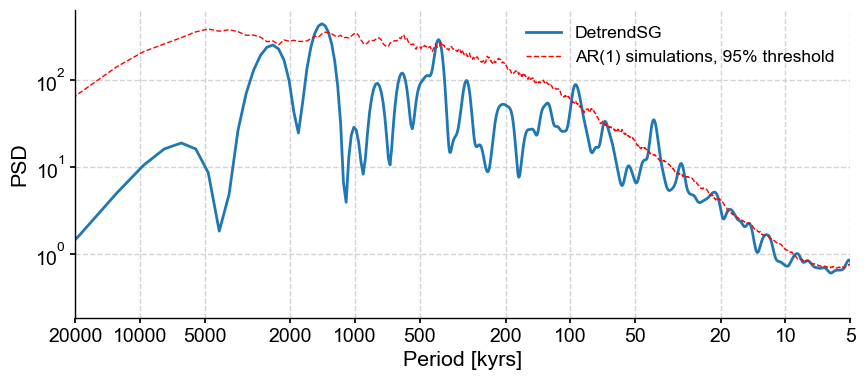

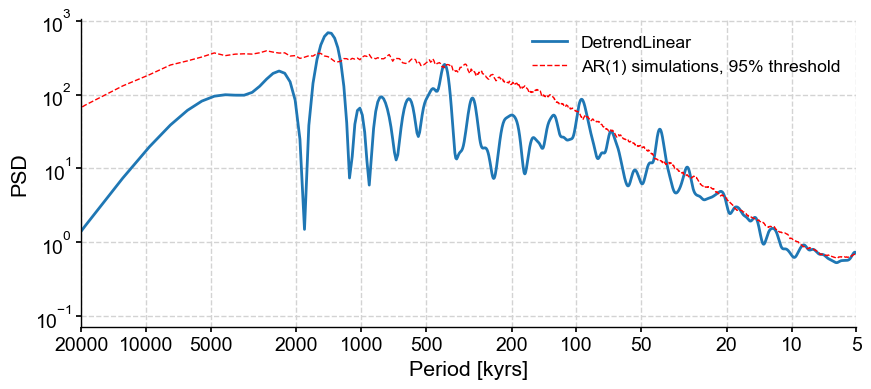

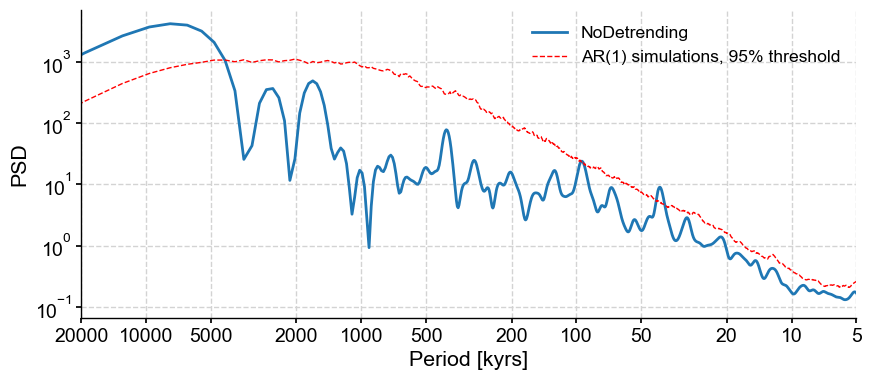

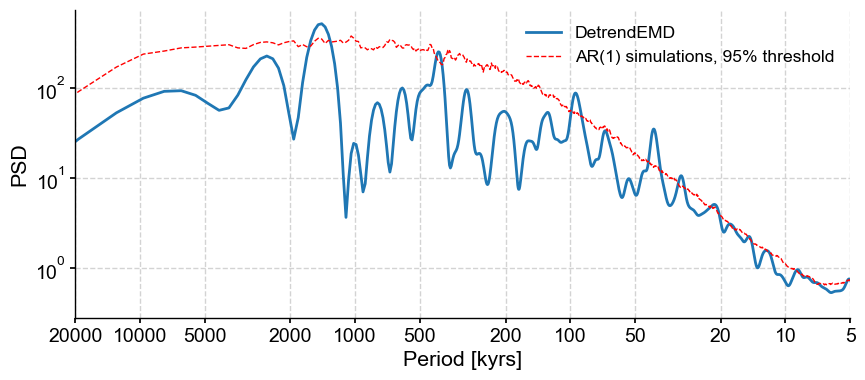

In [96]:
for psd in psd_wwz:
    psd.plot()

Similarly, we observed periodicities at 100kyr. With WWZ, the 40kyr band is more defined, with some cyclicities also defined around 23kyr (precession).

##### Comparison between the two methods

Let's plot the PSD obtained from Lomb-Scargle and WWZ on the same plots, ignoring the significance tests.

/var/folders/xj/p7h9764x7cx0by8547l04rrr0000gn/T/ipykernel_2804/410996021.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  file = df[df['DBSCAN']==True][df[item]==True][df['remove']=='false'][df['wwz-psd']==True]['OutputPSD'].unique()
/var/folders/xj/p7h9764x7cx0by8547l04rrr0000gn/T/ipykernel_2804/410996021.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  file = df[df['DBSCAN']==True][df[item]==True][df['remove']=='false'][df['LombScargle']==True]['OutputPSD'].unique()


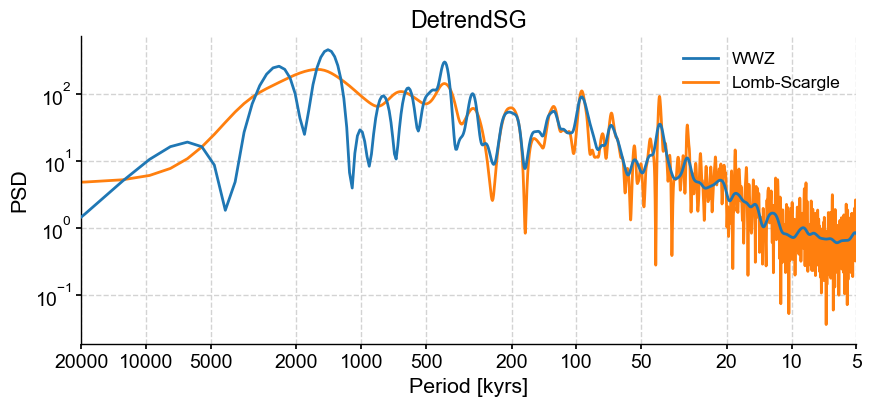

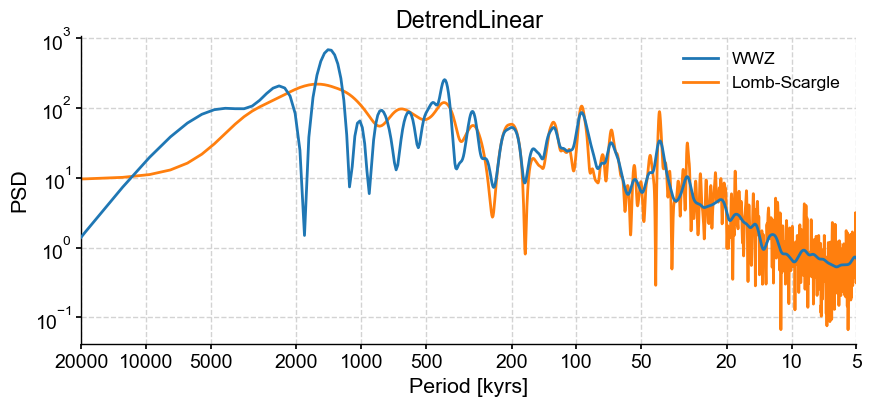

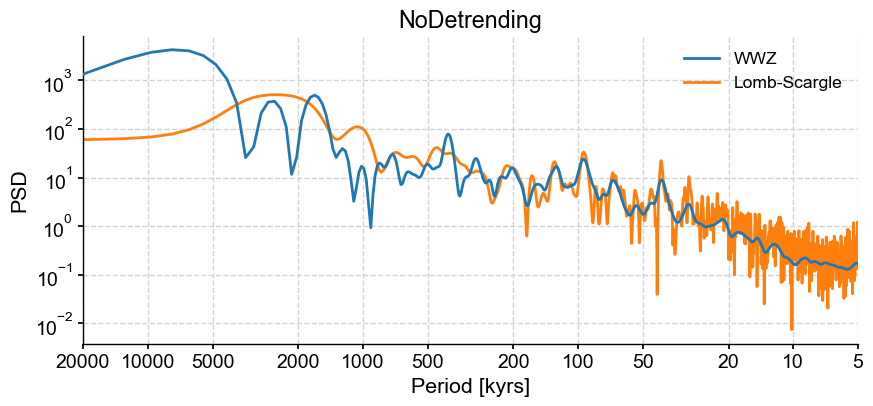

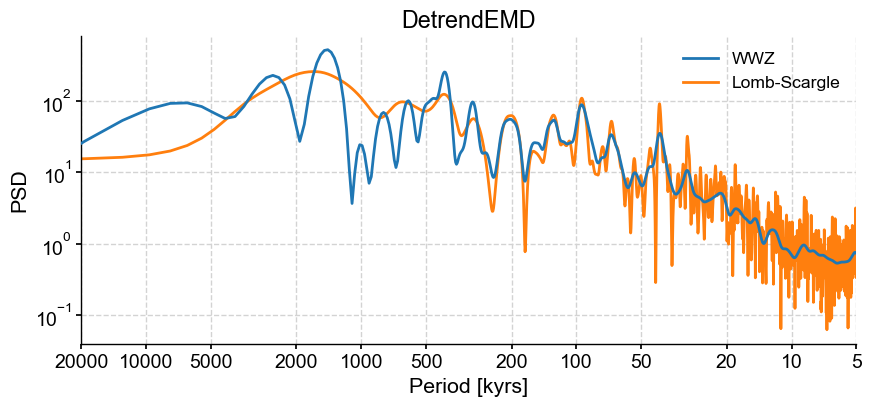

In [98]:
detrend_opt = ['DetrendSG','DetrendLinear','NoDetrending','DetrendEMD']

#WWZ psds
psd_wwz =[]
for item in detrend_opt:
    file = df[df['DBSCAN']==True][df[item]==True][df['remove']=='false'][df['wwz-psd']==True]['OutputPSD'].unique()
    if len(file)>1:
        raise ValueError('Should only get one unique file from this query')
    else:
        psd=pyleo.utils.jsonutils.json_to_PyleoObj(file[0], 'PSD')
        psd.label = 'WWZ'
        psd_wwz.append(psd)

#Lomb-Scargle psds
psd_LS =[]
for item in detrend_opt:
    file = df[df['DBSCAN']==True][df[item]==True][df['remove']=='false'][df['LombScargle']==True]['OutputPSD'].unique()
    if len(file)>1:
        raise ValueError('Should only get one unique file from this query')
    else:
        psd=pyleo.utils.jsonutils.json_to_PyleoObj(file[0], 'PSD')
        psd.label = 'Lomb-Scargle'
        psd_LS.append(psd)

#plot

for idx,item in enumerate(psd_wwz):
    fig,ax=item.plot(title=detrend_opt[idx],zorder=5)
    psd_LS[idx].plot(ax=ax)

The noise in the high frequencies from Lomb-Scargle is expected; however, both methods return similar results for periodicities greater than 20kyr, which correspond to the orbital band. 

#### General signal-processing methods

##### Periodogram

The most basic signal processing method is Periodogram obtained through Fourier Transform. Let's first examine the effects of trends on the results (we will assume a linear interpolation): 

/var/folders/xj/p7h9764x7cx0by8547l04rrr0000gn/T/ipykernel_2804/4072030982.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  file = df[df['DBSCAN']==True][df[item]==True][df['remove']=='false'][df['LinearInterpolation']==True][df['Periodogram']==True]['OutputPSDSig'].unique()


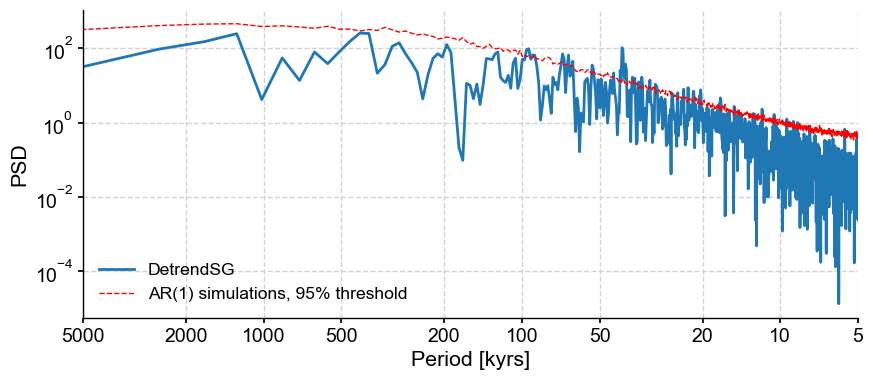

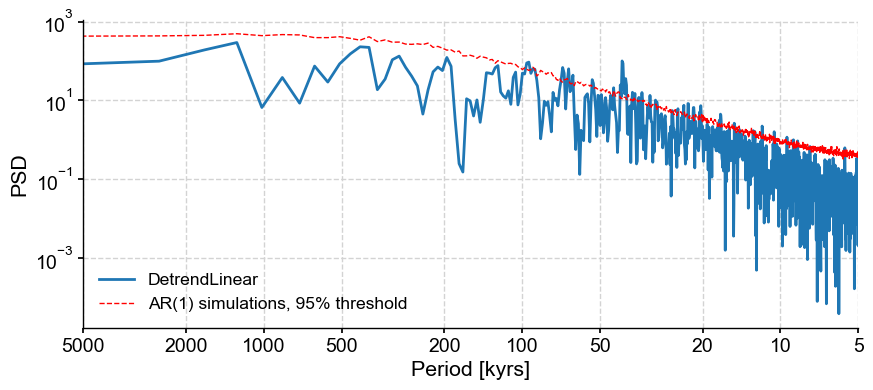

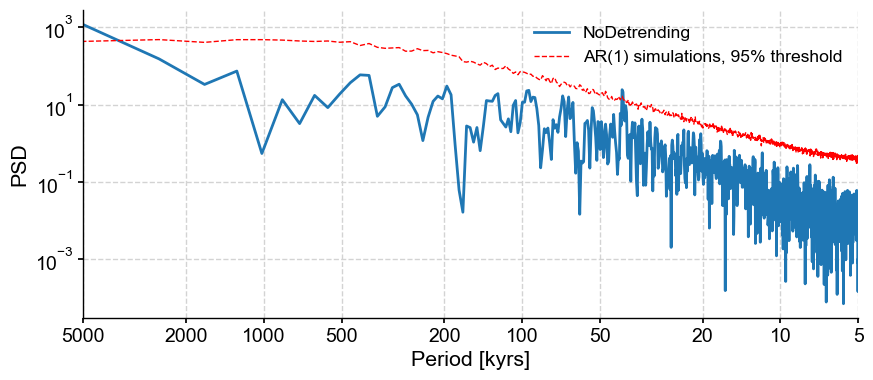

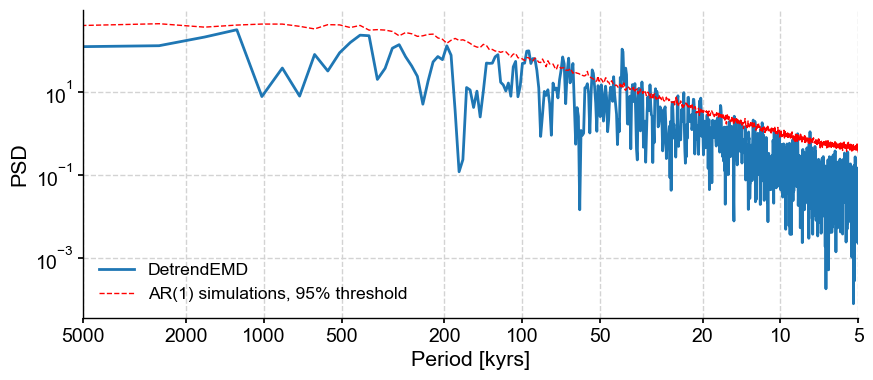

In [100]:
detrend_opt = ['DetrendSG','DetrendLinear','NoDetrending','DetrendEMD']
psd_per =[]

for item in detrend_opt:
    file = df[df['DBSCAN']==True][df[item]==True][df['remove']=='false'][df['LinearInterpolation']==True][df['Periodogram']==True]['OutputPSDSig'].unique()
    if len(file)>1:
        raise ValueError('Should only get one unique file from this query')
    else:
        psd=pyleo.utils.jsonutils.json_to_PyleoObj(file[0], 'PSD')
        psd.label = item
        psd_per.append(psd)

for psd in psd_per:
    psd.plot()

The detection of these orbital cycles are more muted when using a simple Fourier transform, with the cycle corresponding to eccentricity losing its significance when the series is not properly detrended. 

Let's have a look at the influence of our regridding approach (using a detrending approach through EMD):

/var/folders/xj/p7h9764x7cx0by8547l04rrr0000gn/T/ipykernel_2804/2337895241.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  file = df[df['DBSCAN']==True][df[item]==True][df['remove']=='false'][df['DetrendEMD']==True][df['Periodogram']==True]['OutputPSDSig'].unique()


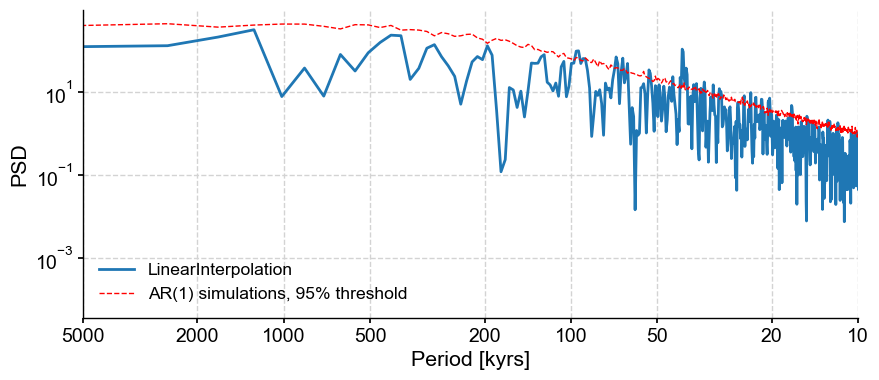

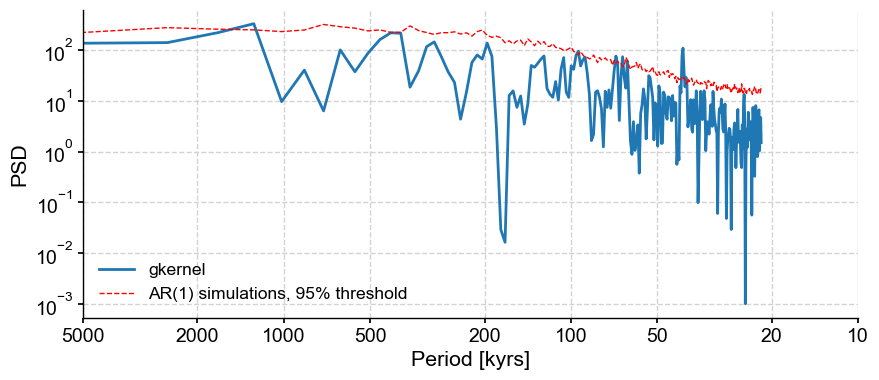

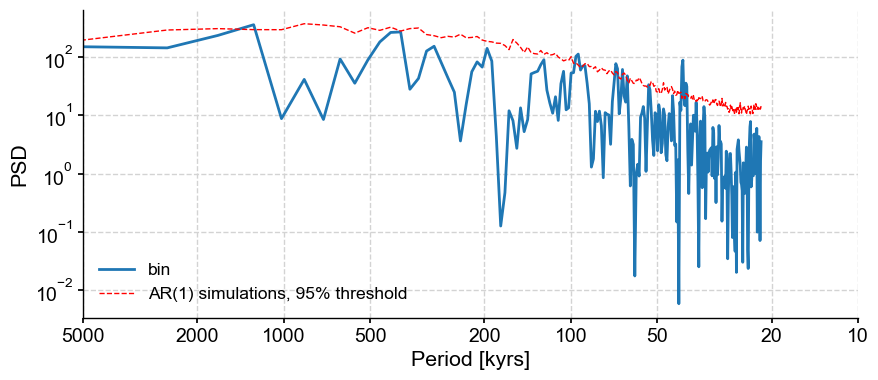

In [127]:
regrid_opt = ['LinearInterpolation','gkernel','bin']
psd_per =[]

for item in regrid_opt:
    file = df[df['DBSCAN']==True][df[item]==True][df['remove']=='false'][df['DetrendEMD']==True][df['Periodogram']==True]['OutputPSDSig'].unique()
    if len(file)>1:
        raise ValueError('Should only get one unique file from this query')
    else:
        psd=pyleo.utils.jsonutils.json_to_PyleoObj(file[0], 'PSD')
        psd.label = item
        psd_per.append(psd)

for psd in psd_per:
    xticks = [10,20,50,100,200,500,1000,2000,5000]
    fig,ax = psd.plot(xlim=[10,5000])
    ax.invert_xaxis()
    ax.set_xticks(xticks)

The choice of regridding method impacts the location of peaks below a periodicity of ~70kyr, making the peaks corresponsing to obliquity and precession more spurious.

##### Welch

The Welch method employs an overlapping segment approach to reduce the noise in the estimated periodogram (at the expanse of reducing the frequency resolution). 

Let's look at the effect of detrending:

/var/folders/xj/p7h9764x7cx0by8547l04rrr0000gn/T/ipykernel_2804/3598719699.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  file = df[df['DBSCAN']==True][df[item]==True][df['remove']=='false'][df['LinearInterpolation']==True][df['Welch']==True]['OutputPSDSig'].unique()


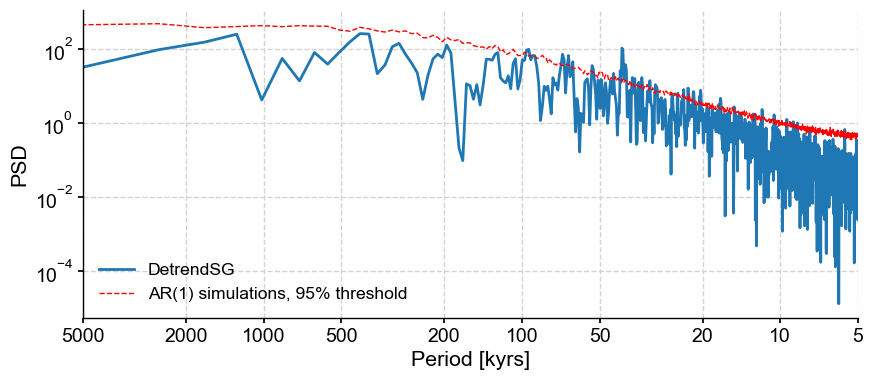

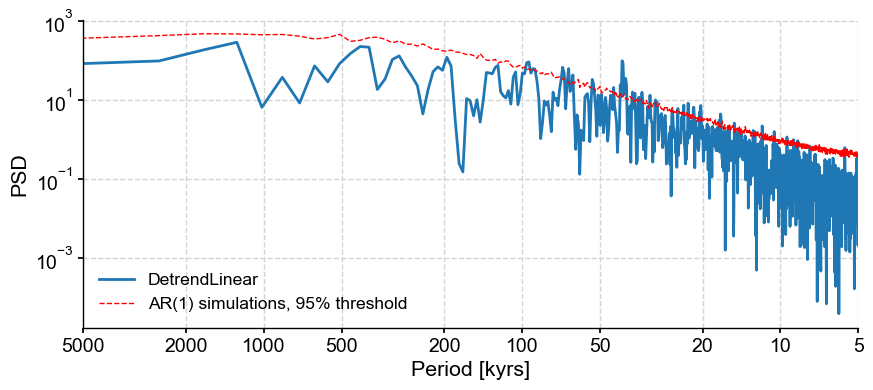

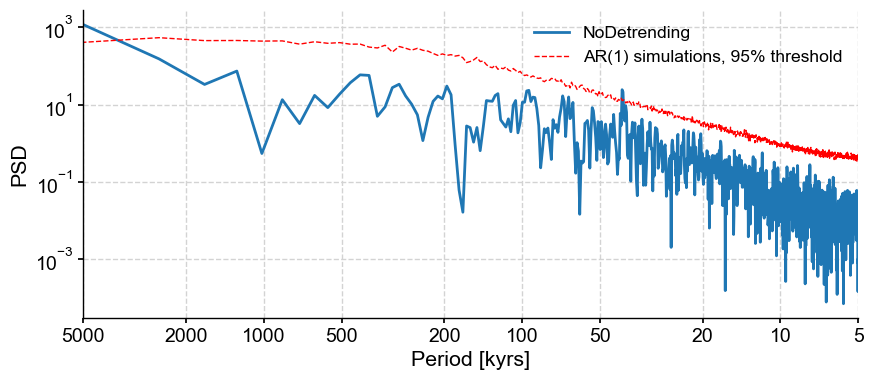

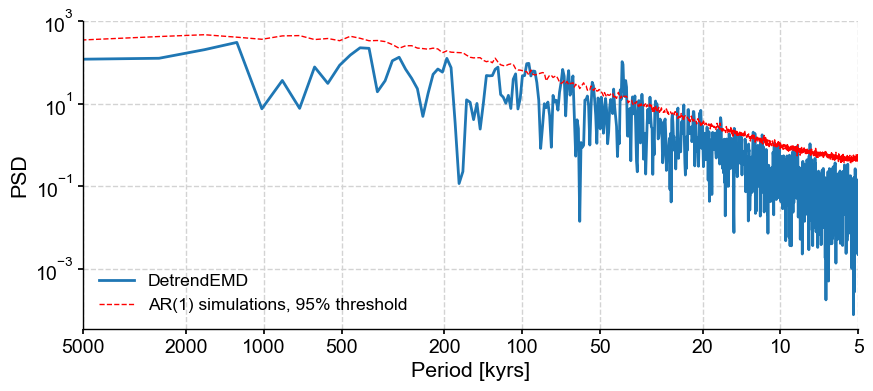

In [132]:
detrend_opt = ['DetrendSG','DetrendLinear','NoDetrending','DetrendEMD']
psd_welch =[]

for item in detrend_opt:
    file = df[df['DBSCAN']==True][df[item]==True][df['remove']=='false'][df['LinearInterpolation']==True][df['Welch']==True]['OutputPSDSig'].unique()
    if len(file)>1:
        raise ValueError('Should only get one unique file from this query')
    else:
        psd=pyleo.utils.jsonutils.json_to_PyleoObj(file[0], 'PSD')
        psd.label = item
        psd_welch.append(psd)

for psd in psd_welch:
    psd.plot()

The results from the Welch method are similar to that obtained from the Periodogram, which is not surprising since these two methods share the same windowing and transform. 

##### MTM

/var/folders/xj/p7h9764x7cx0by8547l04rrr0000gn/T/ipykernel_2804/4064512486.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  file = df[df['DBSCAN']==True][df[item]==True][df['remove']=='false'][df['LinearInterpolation']==True][df['Welch']==True]['OutputPSDSig'].unique()


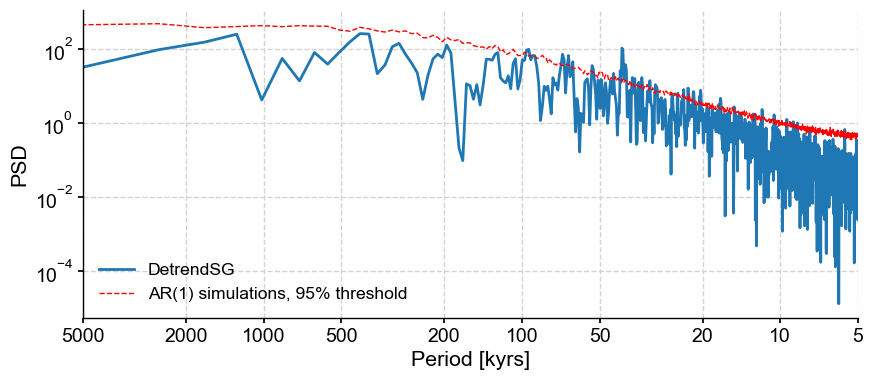

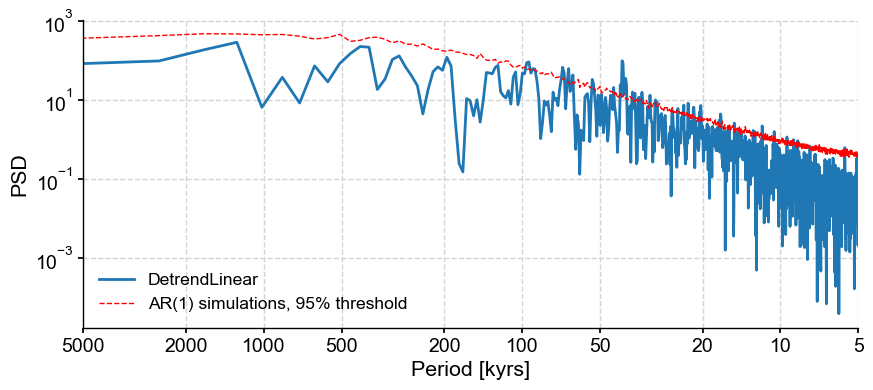

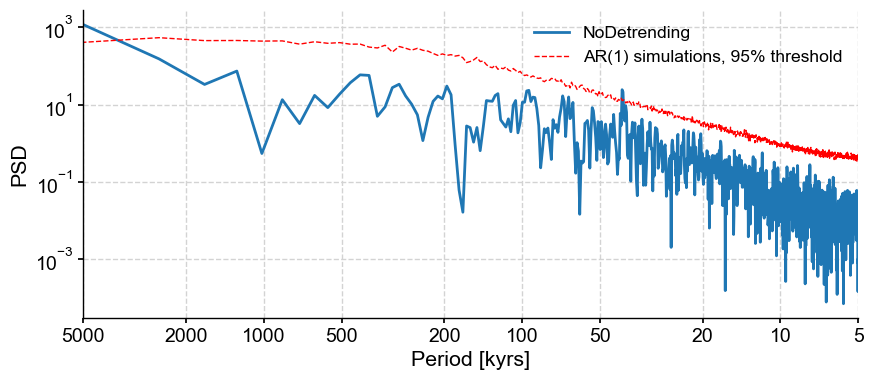

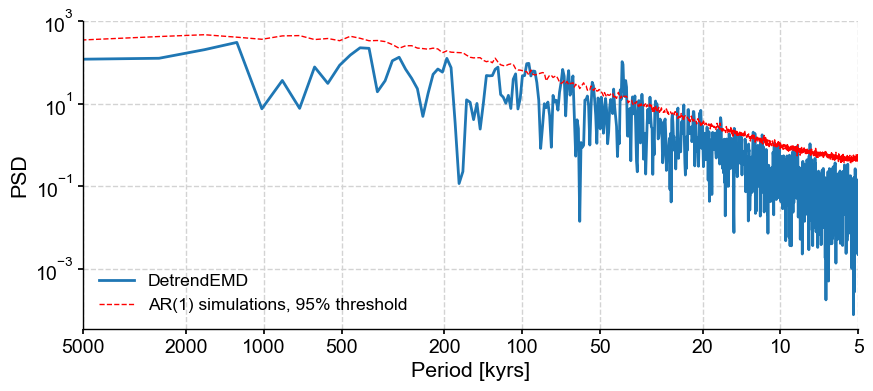

In [133]:
detrend_opt = ['DetrendSG','DetrendLinear','NoDetrending','DetrendEMD']
psd_mtm =[]

for item in detrend_opt:
    file = df[df['DBSCAN']==True][df[item]==True][df['remove']=='false'][df['LinearInterpolation']==True][df['Welch']==True]['OutputPSDSig'].unique()
    if len(file)>1:
        raise ValueError('Should only get one unique file from this query')
    else:
        psd=pyleo.utils.jsonutils.json_to_PyleoObj(file[0], 'PSD')
        psd.label = item
        psd_mtm.append(psd)

for psd in psd_mtm:
    psd.plot()

We obtain very similar results using the MTM method. 

**Preliminary conclusions**: Regardless of the spectral method used and the pre-processing applied to the timeseries (with the exception of no detrending, which may not be the best choice given the strong trend in this particular timeseries), the sea surface temperature record displays significant periodicities in the orbital band, defined broadly as the 20-100kyr band.

The question remains as to whether the specific peaks associated with the known eccentricity, obliquity, and precession cycles can be specifically isolated.

#### Peaks associated with eccentricity, obliquity, and precession

Let's examine whether we can detect significant periodicities centered around 100kyr, 40kyr, and 23kyr. Here, we will define significant as (1) being above red noise, (2) with the tallest peak being within 5kyr of the known oribtal cycle, and (3) being the tallest significant peak within 10kyr of the known orbital cycle.

First, let's only consider the runs with the following pre-processing steps:

- Detrending using the linear, Savitzy-Golay, EMD
- No removal of outliers
- For methods requiring regridding: linear interpolation, binning and gkernel.

In [136]:
df_out = df[df['DBSCAN']==True][df['remove']=='false'][df['NoDetrending'].isna()]

/var/folders/xj/p7h9764x7cx0by8547l04rrr0000gn/T/ipykernel_2804/994906182.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_out = df[df['DBSCAN']==True][df['remove']=='false'][df['NoDetrending'].isna()]


In [ ]:
def find_orbital_peaks(psd, tol = 5, 